In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import glob
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math
import warnings
from matplotlib import dates
import random

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import yfinance as yf

from sklearn.preprocessing import StandardScaler


%matplotlib inline
warnings.filterwarnings(action='ignore')
%cd '/content/drive/MyDrive/Paper/Writing/Deep learning approach of the US stock market analysis and its explanation using correlation networks/code/'

/content/drive/MyDrive/Paper/Writing/Deep learning approach of the US stock market analysis and its explanation using correlation networks/code


In [5]:
def set_seed(seed_num):
  tf.random.set_seed(seed_num)
  np.random.seed(seed_num)
  random.seed(seed_num)
  os.environ['PYTHONHASHSEED']=str(seed_num)

seed_num = 42
set_seed(seed_num)

## 1. Load dataset

- Check the closing price of all companys of dow 30 from 2008-06-01 to 2021-01-29 (per day, 3189 days)
- except 'dow' stock

In [6]:
stock_id = ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
'DIS', 'DOW', 'XOM', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE',
'PG', 'TRV', 'UNH', 'VZ', 'V', 'WMT', 'WBA', 'RTX']

In [7]:
for i in range(30):
  data=yf.download(stock_id[i], start='2008-06-01', interval='1d',  end='2021-01-30',progress=False)[['Close']]
  print(stock_id[i])
  print(data, '\n')

MMM
                 Close
Date                  
2008-06-02   76.250000
2008-06-03   76.230003
2008-06-04   76.360001
2008-06-05   77.500000
2008-06-06   74.860001
...                ...
2021-01-25  170.389999
2021-01-26  175.949997
2021-01-27  186.649994
2021-01-28  183.419998
2021-01-29  175.660004

[3189 rows x 1 columns] 

AXP
                 Close
Date                  
2008-06-02   45.250000
2008-06-03   44.310001
2008-06-04   45.639999
2008-06-05   47.430000
2008-06-06   44.650002
...                ...
2021-01-25  121.150002
2021-01-26  116.150002
2021-01-27  114.089996
2021-01-28  118.970001
2021-01-29  116.260002

[3189 rows x 1 columns] 

AAPL
                 Close
Date                  
2008-06-02    6.646429
2008-06-03    6.620357
2008-06-04    6.613929
2008-06-05    6.765357
2008-06-06    6.630000
...                ...
2021-01-25  142.919998
2021-01-26  143.160004
2021-01-27  142.059998
2021-01-28  137.089996
2021-01-29  131.960007

[3189 rows x 1 columns] 

BA
      

In [8]:
stock_id2 = ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
'DIS', 'XOM', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE',
'PG', 'TRV', 'UNH', 'VZ', 'V', 'WMT', 'WBA', 'RTX']  # except DOW (different in comes to yf)

In [9]:
all_orig_data = pd.DataFrame()
for st in stock_id2:
  print(st)
  data = yf.download(st, start='2008-06-01', interval='1d',  end='2021-01-30',progress = False)[['Close']]
  all_orig_data[st] = data

MMM
AXP
AAPL
BA
CAT
CVX
CSCO
KO
DIS
XOM
GS
HD
IBM
INTC
JNJ
JPM
MCD
MRK
MSFT
NKE
PFE
PG
TRV
UNH
VZ
V
WMT
WBA
RTX


In [10]:
all_orig_data

MMM         AXP        AAPL          BA         CAT  \
Date                                                                     
2008-06-02   76.250000   45.250000    6.646429   81.150002   82.330002   
2008-06-03   76.230003   44.310001    6.620357   78.120003   82.419998   
2008-06-04   76.360001   45.639999    6.613929   78.019997   82.459999   
2008-06-05   77.500000   47.430000    6.765357   77.309998   82.730003   
2008-06-06   74.860001   44.650002    6.630000   73.160004   79.989998   
...                ...         ...         ...         ...         ...   
2021-01-25  170.389999  121.150002  142.919998  203.360001  187.339996   
2021-01-26  175.949997  116.150002  143.160004  202.059998  187.210007   
2021-01-27  186.649994  114.089996  142.059998  194.029999  180.630005   
2021-01-28  183.419998  118.970001  137.089996  197.229996  184.339996   
2021-01-29  175.660004  116.260002  131.960007  194.190002  182.839996   

                  CVX       CSCO         KO         DIS        XOM  ...  \
Date                                                                ...   
2008-06-02  99.370003  26.350000  28.500000   33.299999  87.809998  ...   
2008-06-03  97.860001  26.340000  28.200001   33.180000  85.709999  ...   
2008-06-04  96.040001  26.760000  28.350000   34.349998  85.750000  ...   
2008-06-05  99.989998  27.540001  28.594999   34.490002  89.309998  ...   
2008-06-06  99.500000  26.540001  27.900000   33.009998  86.790001  ...   
...               ...        ...        ...         ...        ...  ...   
2021-01-25  90.900002  45.029999  48.779999  171.889999  46.900002  ...   
2021-01-26  89.360001  45.259998  49.290001  169.559998  45.869999  ...   
2021-01-27  88.199997  45.700001  48.529999  163.029999  45.349998  ...   
2021-01-28  89.019997  45.340000  49.150002  171.880005  46.060001  ...   
2021-01-29  85.199997  44.580002  48.150002  168.169998  44.840000  ...   

                   NKE        PFE          PG         TRV         UNH  \
Date                                                                    
2008-06-02   16.785000  18.197344   65.360001   49.279999   33.990002   
2008-06-03   16.742500  18.036053   65.410004   49.299999   33.950001   
2008-06-04   16.985001  17.836811   66.449997   49.230000   33.820000   
2008-06-05   17.517500  17.713472   66.669998   50.240002   33.939999   
2008-06-06   16.982500  17.039848   65.370003   47.250000   33.029999   
...                ...        ...         ...         ...         ...   
2021-01-25  137.550003  37.279999  132.240005  146.360001  347.809998   
2021-01-26  135.100006  37.310001  133.089996  143.710007  343.109985   
2021-01-27  131.020004  36.240002  128.380005  139.500000  332.989990   
2021-01-28  134.720001  35.860001  130.360001  140.000000  338.149994   
2021-01-29  133.589996  35.900002  128.210007  136.300003  333.579987   

                   VZ           V         WMT        WBA        RTX  
Date                                                                 
2008-06-02  35.508476   21.517500   57.200001  36.110001  44.512272  
2008-06-03  35.039532   21.889999   57.770000  36.340000  43.901825  
2008-06-04  34.683136   21.370001   57.680000  36.340000  43.587162  
2008-06-05  36.540154   21.809999   59.799999  36.700001  44.033985  
2008-06-06  35.855495   20.912500   58.369999  35.529999  42.171177  
...               ...         ...         ...        ...        ...  
2021-01-25  58.419998  200.979996  146.199997  47.820000  66.279999  
2021-01-26  56.570000  202.009995  147.509995  49.189999  67.199997  
2021-01-27  55.130001  194.970001  143.839996  51.180000  65.500000  
2021-01-28  55.369999  198.220001  143.750000  50.680000  68.169998  
2021-01-29  54.750000  193.250000  140.490005  50.250000  66.730003  

[3189 rows x 29 columns]

## 2. Visualization of closing price (original dataset)

In [11]:
all_orig_data.index

DatetimeIndex(['2008-06-02', '2008-06-03', '2008-06-04', '2008-06-05',
               '2008-06-06', '2008-06-09', '2008-06-10', '2008-06-11',
               '2008-06-12', '2008-06-13',
               ...
               '2021-01-15', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', name='Date', length=3189, freq=None)

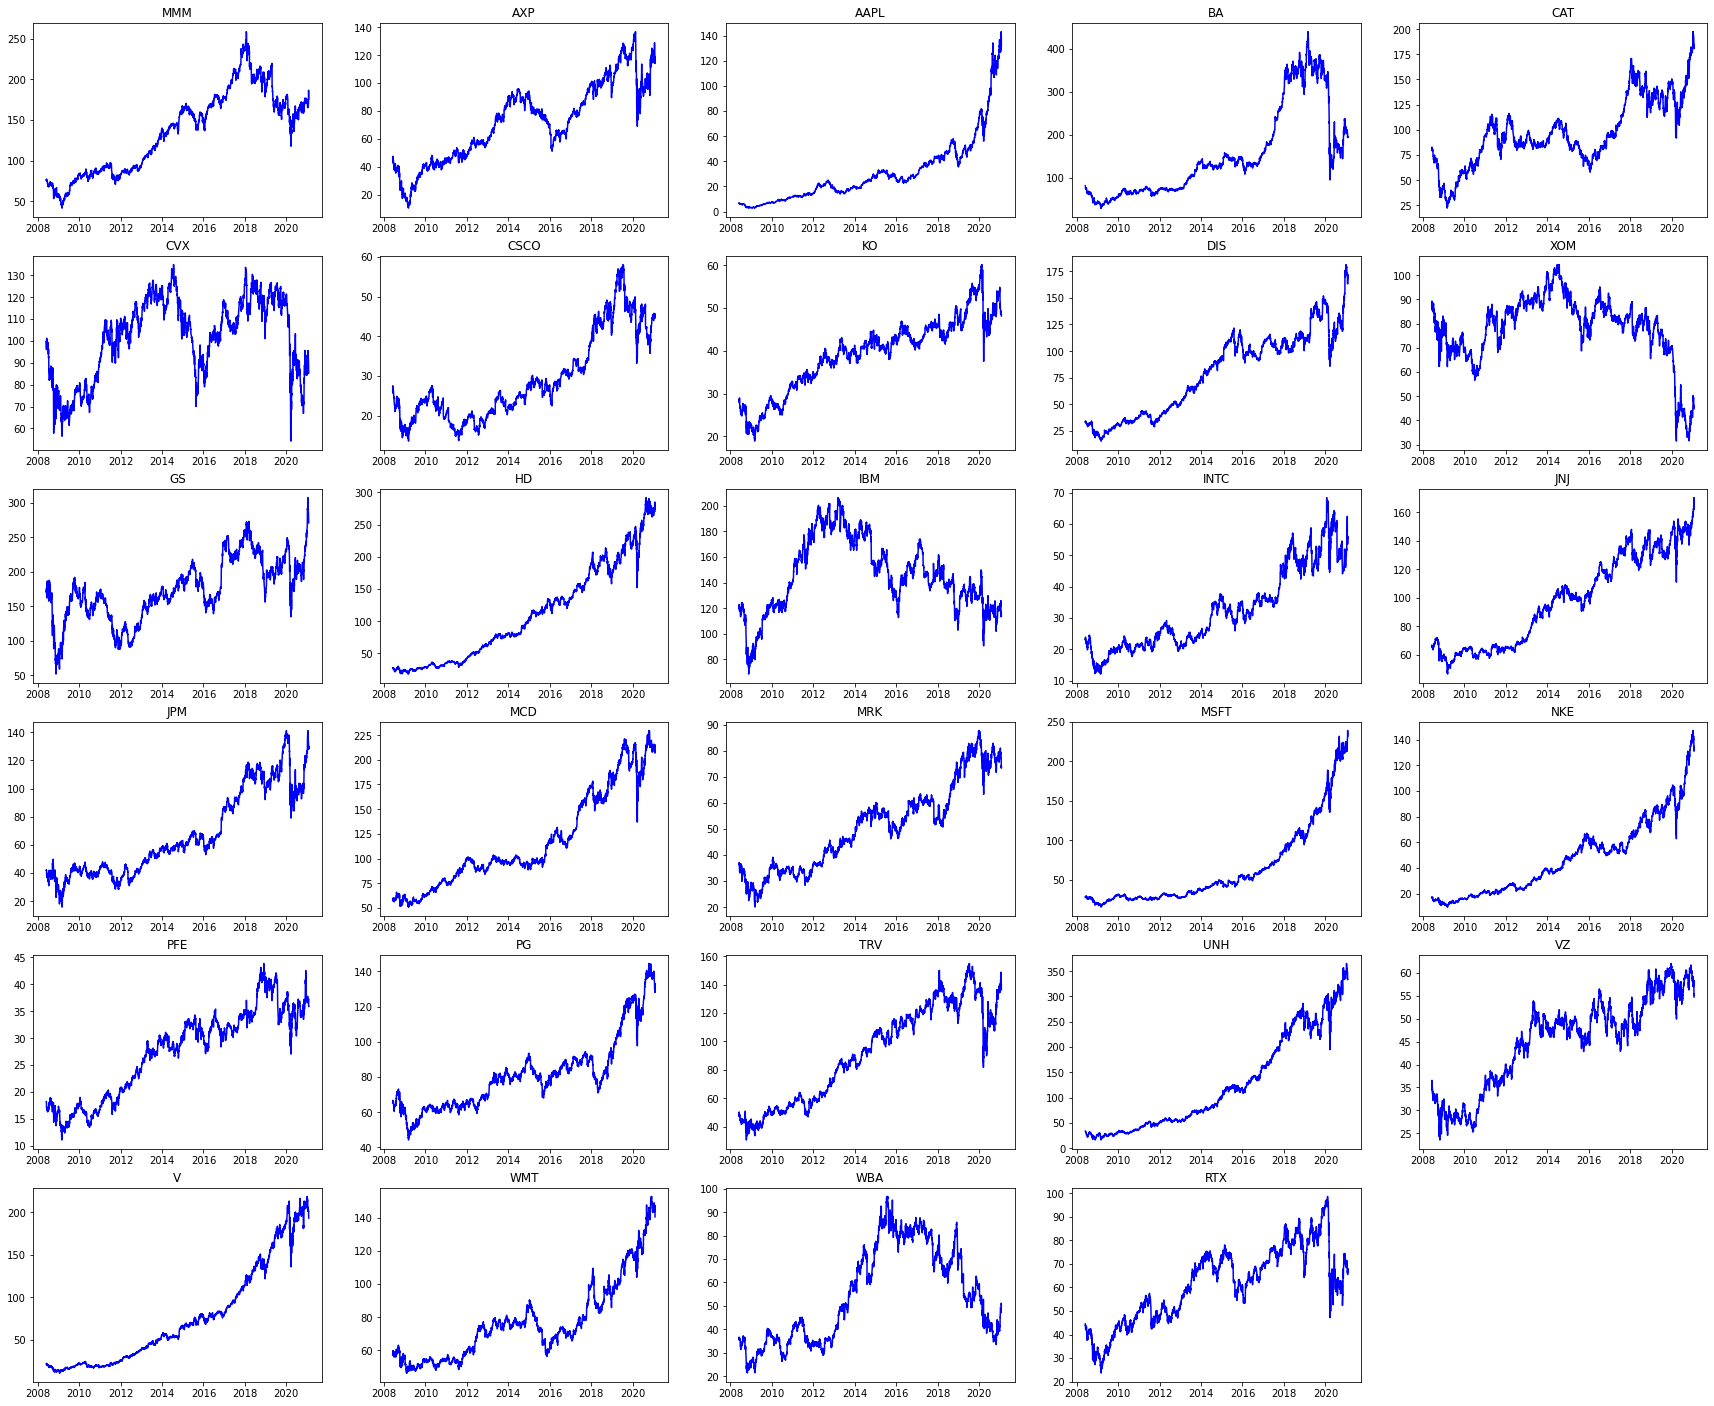

In [ ]:
fig = plt.figure(figsize=(30,25)) 
fig.set_facecolor('white')

for i in range(0,len(stock_id2)):
    
    ax = fig.add_subplot(6,5,i+1)

    # plt.title("Closing price of {}".format(stock_id2[i])) 
    plt.title(stock_id2[i])
    ax.plot(all_orig_data.index, all_orig_data[stock_id2[i]], marker='', color="blue")
plt.savefig('fig/all_closing.png', dpi=300) 
plt.savefig('fig/all_closing.eps', dpi=300)   
plt.show()

- Check the time range

In [12]:
all_orig_data.index

DatetimeIndex(['2008-06-02', '2008-06-03', '2008-06-04', '2008-06-05',
               '2008-06-06', '2008-06-09', '2008-06-10', '2008-06-11',
               '2008-06-12', '2008-06-13',
               ...
               '2021-01-15', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', name='Date', length=3189, freq=None)

In [13]:
all_orig_data.index[np.arange(0, len(all_orig_data.index), 400)]

DatetimeIndex(['2008-06-02', '2009-12-31', '2011-08-03', '2013-03-08',
               '2014-10-08', '2016-05-11', '2017-12-11', '2019-07-17'],
              dtype='datetime64[ns]', name='Date', freq=None)

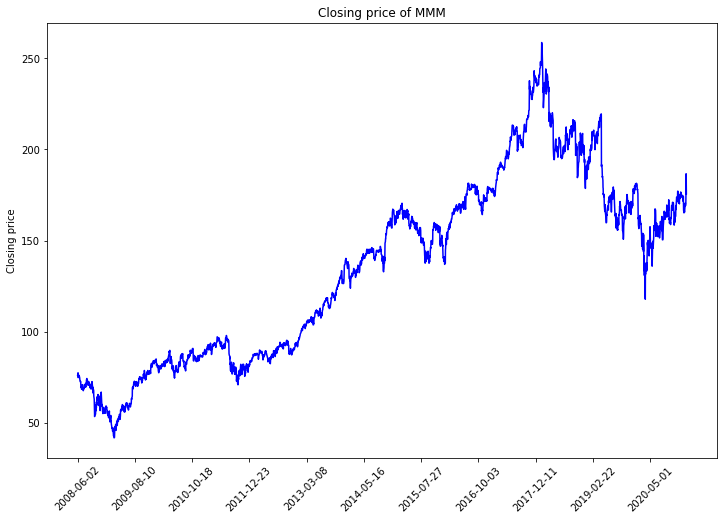

In [ ]:
fig = plt.figure(figsize=(12, 8)) 

plt.title("Closing price of {}".format(stock_id2[0])) 
plt.ylabel('Closing price')

plt.plot(all_orig_data.index, all_orig_data[stock_id2[0]], marker='', color="blue")
plt.xticks(all_orig_data.index[np.arange(0, len(all_orig_data.index), 300)], rotation=45)
plt.show()

In [14]:
df_orig = all_orig_data.copy()

## 3. Preprocessing

In [15]:
daily_return = df_orig.pct_change()
daily_return.isnull().sum()

MMM     1
AXP     1
AAPL    1
BA      1
CAT     1
CVX     1
CSCO    1
KO      1
DIS     1
XOM     1
GS      1
HD      1
IBM     1
INTC    1
JNJ     1
JPM     1
MCD     1
MRK     1
MSFT    1
NKE     1
PFE     1
PG      1
TRV     1
UNH     1
VZ      1
V       1
WMT     1
WBA     1
RTX     1
dtype: int64

In [16]:
daily_return = daily_return.dropna()

In [17]:
daily_return.isnull().sum()

MMM     0
AXP     0
AAPL    0
BA      0
CAT     0
CVX     0
CSCO    0
KO      0
DIS     0
XOM     0
GS      0
HD      0
IBM     0
INTC    0
JNJ     0
JPM     0
MCD     0
MRK     0
MSFT    0
NKE     0
PFE     0
PG      0
TRV     0
UNH     0
VZ      0
V       0
WMT     0
WBA     0
RTX     0
dtype: int64

In [18]:
daily_return

MMM       AXP      AAPL        BA       CAT       CVX  \
Date                                                                     
2008-06-03 -0.000262 -0.020773 -0.003923 -0.037338  0.001093 -0.015196   
2008-06-04  0.001705  0.030016 -0.000971 -0.001280  0.000485 -0.018598   
2008-06-05  0.014929  0.039220  0.022895 -0.009100  0.003274  0.041129   
2008-06-06 -0.034065 -0.058613 -0.020007 -0.053680 -0.033120 -0.004900   
2008-06-09  0.012824 -0.012094 -0.021709  0.010798  0.010251  0.017085   
...              ...       ...       ...       ...       ...       ...   
2021-01-25  0.007986 -0.039559  0.027684 -0.012048 -0.023966 -0.009048   
2021-01-26  0.032631 -0.041271  0.001679 -0.006393 -0.000694 -0.016942   
2021-01-27  0.060813 -0.017736 -0.007684 -0.039741 -0.035148 -0.012981   
2021-01-28 -0.017305  0.042773 -0.034985  0.016492  0.020539  0.009297   
2021-01-29 -0.042307 -0.022779 -0.037421 -0.015413 -0.008137 -0.042912   

                CSCO        KO       DIS       XOM  ...       NKE       PFE  \
Date                                                ...                       
2008-06-03 -0.000380 -0.010526 -0.003604 -0.023915  ... -0.002532 -0.008863   
2008-06-04  0.015945  0.005319  0.035262  0.000467  ...  0.014484 -0.011047   
2008-06-05  0.029148  0.008642  0.004076  0.041516  ...  0.031351 -0.006915   
2008-06-06 -0.036311 -0.024305 -0.042911 -0.028216  ... -0.030541 -0.038029   
2008-06-09 -0.004145  0.001075  0.005150  0.026270  ...  0.009569  0.003341   
...              ...       ...       ...       ...  ...       ...       ...   
2021-01-25  0.005807  0.005981 -0.005151 -0.011174  ... -0.012917  0.019973   
2021-01-26  0.005108  0.010455 -0.013555 -0.021962  ... -0.017812  0.000805   
2021-01-27  0.009722 -0.015419 -0.038511 -0.011336  ... -0.030200 -0.028679   
2021-01-28 -0.007877  0.012776  0.054285  0.015656  ...  0.028240 -0.010486   
2021-01-29 -0.016762 -0.020346 -0.021585 -0.026487  ... -0.008388  0.001115   

                  PG       TRV       UNH        VZ         V       WMT  \
Date                                                                     
2008-06-03  0.000765  0.000406 -0.001177 -0.013207  0.017311  0.009965   
2008-06-04  0.015900 -0.001420 -0.003829 -0.010171 -0.023755 -0.001558   
2008-06-05  0.003311  0.020516  0.003548  0.053542  0.020590  0.036754   
2008-06-06 -0.019499 -0.059514 -0.026812 -0.018737 -0.041151 -0.023913   
2008-06-09  0.010708  0.011429 -0.003028 -0.007586 -0.018051  0.020559   
...              ...       ...       ...       ...       ...       ...   
2021-01-25  0.017231  0.003566  0.000748  0.016530 -0.005148 -0.000888   
2021-01-26  0.006428 -0.018106 -0.013513 -0.031667  0.005125  0.008960   
2021-01-27 -0.035390 -0.029295 -0.029495 -0.025455 -0.034850 -0.024880   
2021-01-28  0.015423  0.003584  0.015496  0.004353  0.016669 -0.000626   
2021-01-29 -0.016493 -0.026429 -0.013515 -0.011197 -0.025073 -0.022678   

                 WBA       RTX  
Date                            
2008-06-03  0.006369 -0.013714  
2008-06-04  0.000000 -0.007167  
2008-06-05  0.009906  0.010251  
2008-06-06 -0.031880 -0.042304  
2008-06-09  0.002533  0.008058  
...              ...       ...  
2021-01-25  0.007798 -0.019237  
2021-01-26  0.028649  0.013880  
2021-01-27  0.040455 -0.025298  
2021-01-28 -0.009769  0.040763  
2021-01-29 -0.008485 -0.021124  

[3188 rows x 29 columns]

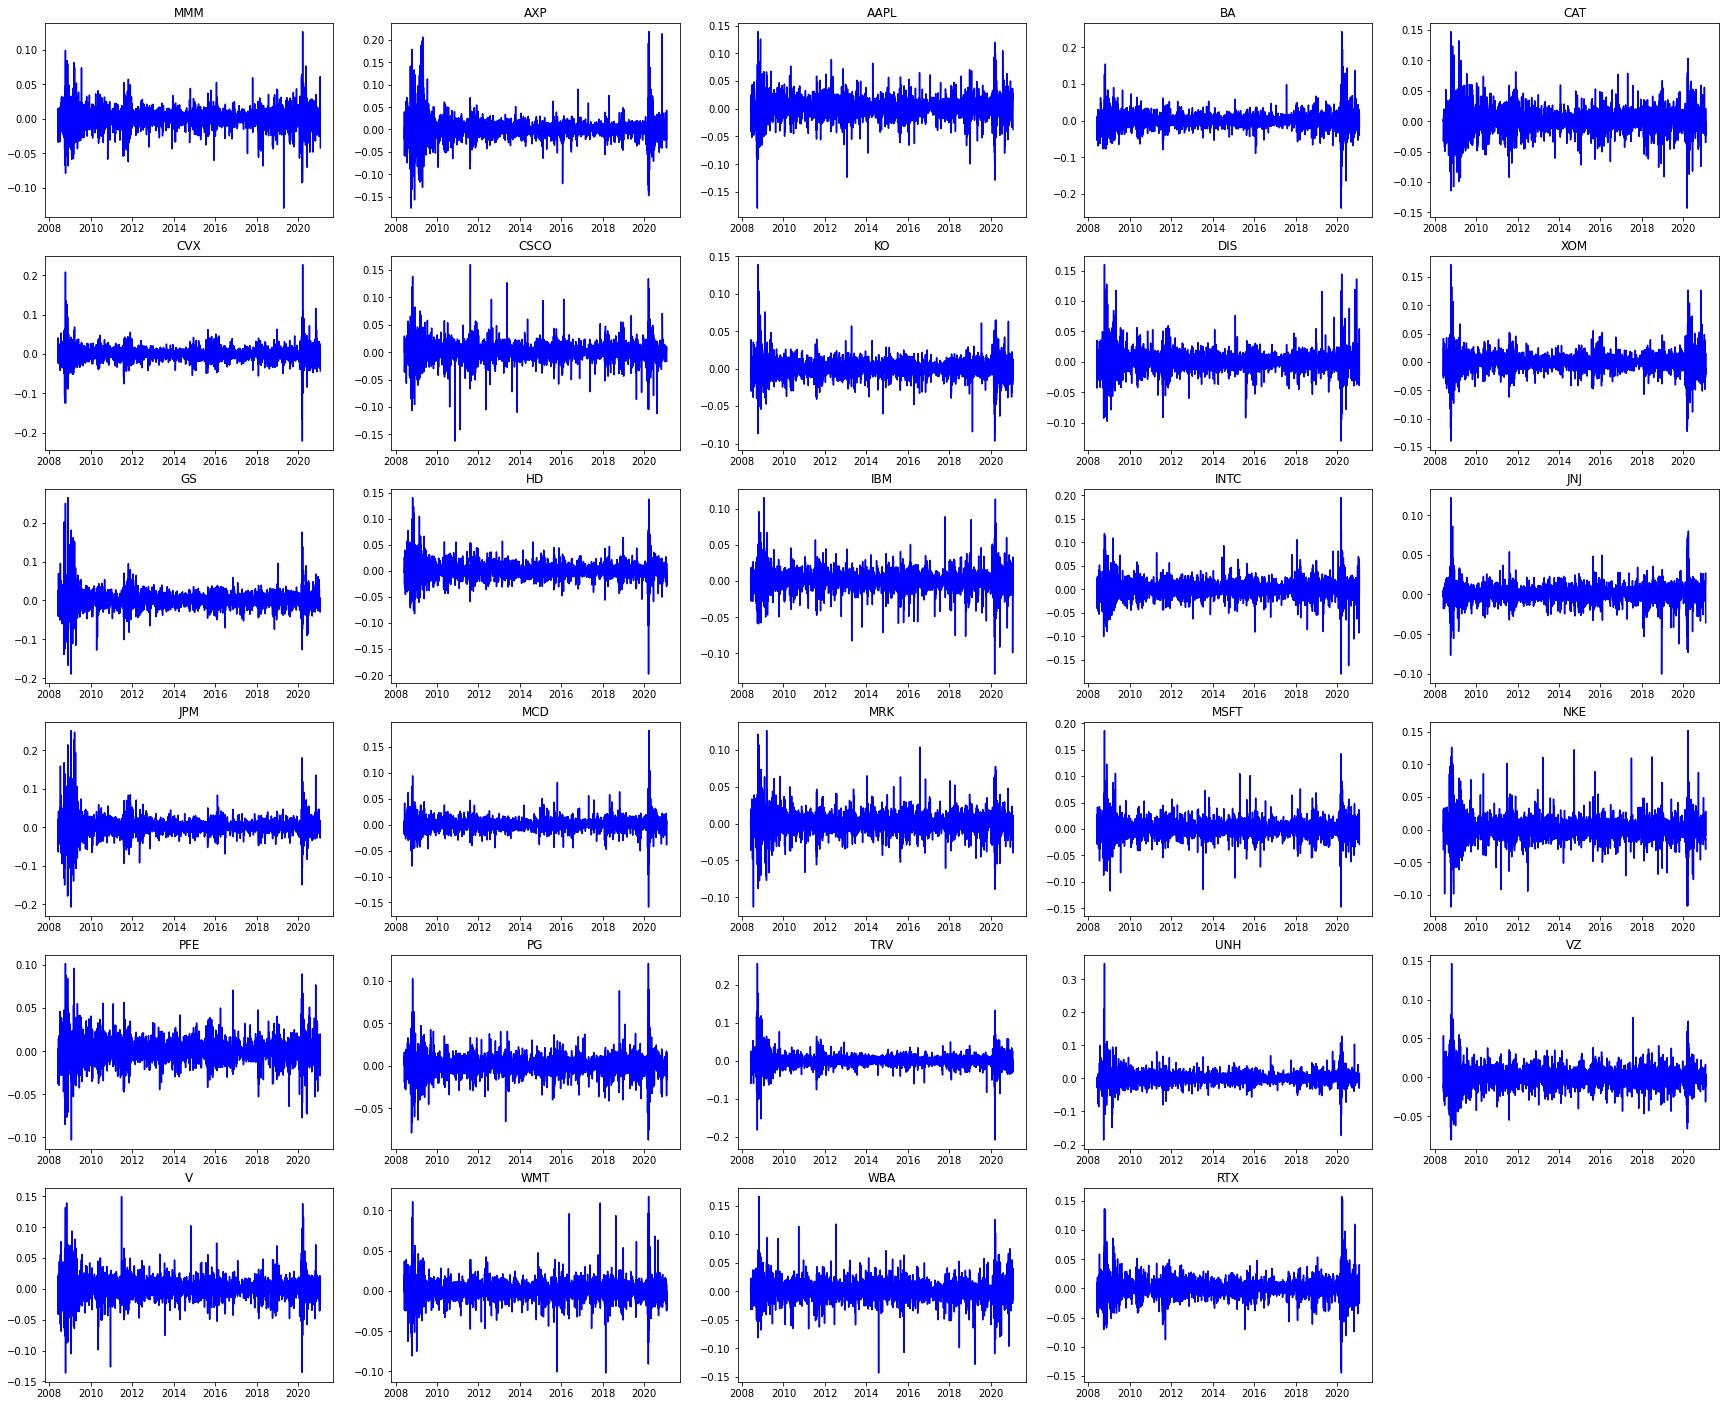

In [ ]:
fig = plt.figure(figsize=(30,25)) 
fig.set_facecolor('white')

for i in range(0,len(stock_id2)):
    
    ax = fig.add_subplot(6,5,i+1)

    plt.title(stock_id2[i]) 
    ax.plot(daily_return.index, daily_return[stock_id2[i]], marker='', color="blue")
plt.savefig('fig/all_return.png', dpi=300) 
# plt.savefig('fig/all_return.eps', dpi=300)   
plt.show()

In [19]:
# train_size = int(len(daily_return) * 0.97)
train_size = 2886  # fix (08.06.02 - 19.11.15)
test_size = len(daily_return) - train_size
train, test = daily_return.iloc[0:train_size], daily_return.iloc[train_size:len(daily_return)]

orig_train, orig_test = df_orig.iloc[0:train_size], df_orig.iloc[train_size+1:len(df_orig)]

In [20]:
print(np.shape(train), np.shape(test))
print(np.shape(orig_train), np.shape(orig_test))

(2886, 29) (302, 29)
(2886, 29) (302, 29)


In [21]:
# Check the time range
print("Train : from", df_orig.index[0], "to", df_orig.index[np.shape(train)[0]])
print("Test : from", df_orig.index[np.shape(train)[0]+1], "to", df_orig.index[len(df_orig.index)-1])

Train : from 2008-06-02 00:00:00 to 2019-11-15 00:00:00
Test : from 2019-11-18 00:00:00 to 2021-01-29 00:00:00


In [22]:
df_train = train.copy()
df_test = test.copy()

In [23]:
df_train

MMM       AXP      AAPL        BA       CAT       CVX  \
Date                                                                     
2008-06-03 -0.000262 -0.020773 -0.003923 -0.037338  0.001093 -0.015196   
2008-06-04  0.001705  0.030016 -0.000971 -0.001280  0.000485 -0.018598   
2008-06-05  0.014929  0.039220  0.022895 -0.009100  0.003274  0.041129   
2008-06-06 -0.034065 -0.058613 -0.020007 -0.053680 -0.033120 -0.004900   
2008-06-09  0.012824 -0.012094 -0.021709  0.010798  0.010251  0.017085   
...              ...       ...       ...       ...       ...       ...   
2019-11-11 -0.017557 -0.004693  0.007919  0.045470 -0.001080 -0.000992   
2019-11-12  0.004291 -0.000083 -0.000915 -0.011118 -0.011216  0.001242   
2019-11-13 -0.001697 -0.005211  0.009582 -0.001047 -0.012642  0.010913   
2019-11-14  0.002228  0.005571 -0.006919  0.013628 -0.007267 -0.002617   
2019-11-15  0.005558 -0.001406  0.011879  0.011539  0.013037 -0.010823   

                CSCO        KO       DIS       XOM  ...       NKE       PFE  \
Date                                                ...                       
2008-06-03 -0.000380 -0.010526 -0.003604 -0.023915  ... -0.002532 -0.008863   
2008-06-04  0.015945  0.005319  0.035262  0.000467  ...  0.014484 -0.011047   
2008-06-05  0.029148  0.008642  0.004076  0.041516  ...  0.031351 -0.006915   
2008-06-06 -0.036311 -0.024305 -0.042911 -0.028216  ... -0.030541 -0.038029   
2008-06-09 -0.004145  0.001075  0.005150  0.026270  ...  0.009569  0.003341   
...              ...       ...       ...       ...  ...       ...       ...   
2019-11-11 -0.014950 -0.007087 -0.008843 -0.006076  ...  0.002672 -0.003239   
2019-11-12  0.005613 -0.002508  0.013456 -0.013790  ... -0.006108  0.001083   
2019-11-13  0.001861  0.013537  0.073171 -0.008217  ...  0.020000 -0.010008   
2019-11-14 -0.073256  0.004198 -0.010557 -0.004361  ... -0.000219 -0.001366   
2019-11-15  0.004008  0.000760 -0.016854  0.010073  ...  0.019393  0.019973   

                  PG       TRV       UNH        VZ         V       WMT  \
Date                                                                     
2008-06-03  0.000765  0.000406 -0.001177 -0.013207  0.017311  0.009965   
2008-06-04  0.015900 -0.001420 -0.003829 -0.010171 -0.023755 -0.001558   
2008-06-05  0.003311  0.020516  0.003548  0.053542  0.020590  0.036754   
2008-06-06 -0.019499 -0.059514 -0.026812 -0.018737 -0.041151 -0.023913   
2008-06-09  0.010708  0.011429 -0.003028 -0.007586 -0.018051  0.020559   
...              ...       ...       ...       ...       ...       ...   
2019-11-11 -0.003091  0.001876 -0.011208  0.004381  0.003185 -0.003349   
2019-11-12 -0.000503 -0.001423  0.004565 -0.004865  0.001114  0.000672   
2019-11-13  0.011570  0.005849 -0.006582  0.001517 -0.001836  0.015615   
2019-11-14 -0.001243 -0.001342  0.008913 -0.001178  0.001895 -0.002728   
2019-11-15  0.000332 -0.002837  0.053043  0.002865  0.000111 -0.014753   

                 WBA       RTX  
Date                            
2008-06-03  0.006369 -0.013714  
2008-06-04  0.000000 -0.007167  
2008-06-05  0.009906  0.010251  
2008-06-06 -0.031880 -0.042304  
2008-06-09  0.002533  0.008058  
...              ...       ...  
2019-11-11  0.050810 -0.004433  
2019-11-12  0.007550  0.001147  
2019-11-13 -0.007494 -0.000539  
2019-11-14 -0.004980 -0.001349  
2019-11-15  0.003229  0.008440  

[2886 rows x 29 columns]

In [24]:
a = df_train.iloc[:33, 0]
print(a)

Date
2008-06-03   -0.000262
2008-06-04    0.001705
2008-06-05    0.014929
2008-06-06   -0.034065
2008-06-09    0.012824
2008-06-10    0.002374
2008-06-11   -0.009605
2008-06-12    0.003720
2008-06-13    0.007545
2008-06-16   -0.012086
2008-06-17   -0.003058
2008-06-18   -0.008937
2008-06-19   -0.002423
2008-06-20   -0.014841
2008-06-23   -0.000822
2008-06-24   -0.007264
2008-06-25    0.001933
2008-06-26   -0.031831
2008-06-27   -0.010675
2008-06-30    0.001151
2008-07-01    0.002730
2008-07-02   -0.018630
2008-07-03    0.014311
2008-07-07    0.005615
2008-07-08    0.016893
2008-07-09   -0.033648
2008-07-10    0.004079
2008-07-11   -0.002902
2008-07-14    0.004365
2008-07-15   -0.019270
2008-07-16    0.014035
2008-07-17    0.011801
2008-07-18   -0.007343
Name: MMM, dtype: float64


In [25]:
print(a.T)

Date
2008-06-03   -0.000262
2008-06-04    0.001705
2008-06-05    0.014929
2008-06-06   -0.034065
2008-06-09    0.012824
2008-06-10    0.002374
2008-06-11   -0.009605
2008-06-12    0.003720
2008-06-13    0.007545
2008-06-16   -0.012086
2008-06-17   -0.003058
2008-06-18   -0.008937
2008-06-19   -0.002423
2008-06-20   -0.014841
2008-06-23   -0.000822
2008-06-24   -0.007264
2008-06-25    0.001933
2008-06-26   -0.031831
2008-06-27   -0.010675
2008-06-30    0.001151
2008-07-01    0.002730
2008-07-02   -0.018630
2008-07-03    0.014311
2008-07-07    0.005615
2008-07-08    0.016893
2008-07-09   -0.033648
2008-07-10    0.004079
2008-07-11   -0.002902
2008-07-14    0.004365
2008-07-15   -0.019270
2008-07-16    0.014035
2008-07-17    0.011801
2008-07-18   -0.007343
Name: MMM, dtype: float64


In [26]:
df_test

MMM       AXP      AAPL        BA       CAT       CVX  \
Date                                                                     
2019-11-18 -0.007796 -0.009109  0.005042 -0.005973 -0.011837 -0.017324   
2019-11-19  0.000821  0.002841 -0.003033 -0.006658 -0.002855 -0.017714   
2019-11-20 -0.017049 -0.005833 -0.011641  0.010654 -0.011594  0.007643   
2019-11-21 -0.015676 -0.004191 -0.004483 -0.012051  0.013002  0.012187   
2019-11-22  0.014896  0.002189 -0.000878  0.013372  0.003627 -0.001179   
...              ...       ...       ...       ...       ...       ...   
2021-01-25  0.007986 -0.039559  0.027684 -0.012048 -0.023966 -0.009048   
2021-01-26  0.032631 -0.041271  0.001679 -0.006393 -0.000694 -0.016942   
2021-01-27  0.060813 -0.017736 -0.007684 -0.039741 -0.035148 -0.012981   
2021-01-28 -0.017305  0.042773 -0.034985  0.016492  0.020539  0.009297   
2021-01-29 -0.042307 -0.022779 -0.037421 -0.015413 -0.008137 -0.042912   

                CSCO        KO       DIS       XOM  ...       NKE       PFE  \
Date                                                ...                       
2019-11-18  0.001331  0.006835  0.020599 -0.009684  ...  0.012253 -0.001609   
2019-11-19  0.007087  0.000943  0.004944 -0.010216  ... -0.006052  0.011822   
2019-11-20 -0.008577  0.002638 -0.009772  0.003096  ... -0.005982 -0.016198   
2019-11-21 -0.005324 -0.004885 -0.000204  0.024107  ... -0.009565  0.018624   
2019-11-22  0.000223  0.001322  0.009462 -0.004306  ...  0.012804  0.015633   
...              ...       ...       ...       ...  ...       ...       ...   
2021-01-25  0.005807  0.005981 -0.005151 -0.011174  ... -0.012917  0.019973   
2021-01-26  0.005108  0.010455 -0.013555 -0.021962  ... -0.017812  0.000805   
2021-01-27  0.009722 -0.015419 -0.038511 -0.011336  ... -0.030200 -0.028679   
2021-01-28 -0.007877  0.012776  0.054285  0.015656  ...  0.028240 -0.010486   
2021-01-29 -0.016762 -0.020346 -0.021585 -0.026487  ... -0.008388  0.001115   

                  PG       TRV       UNH        VZ         V       WMT  \
Date                                                                     
2019-11-18  0.011200  0.005390  0.013103 -0.001176 -0.000612  0.011609   
2019-11-19 -0.003856  0.008713  0.004763  0.001009  0.017310 -0.002994   
2019-11-20  0.007165 -0.000222  0.004850 -0.000336 -0.006073 -0.006339   
2019-11-21 -0.015946 -0.005464  0.003593  0.002186 -0.009744  0.006128   
2019-11-22 -0.000415  0.003267  0.001049  0.002349 -0.002335 -0.004172   
...              ...       ...       ...       ...       ...       ...   
2021-01-25  0.017231  0.003566  0.000748  0.016530 -0.005148 -0.000888   
2021-01-26  0.006428 -0.018106 -0.013513 -0.031667  0.005125  0.008960   
2021-01-27 -0.035390 -0.029295 -0.029495 -0.025455 -0.034850 -0.024880   
2021-01-28  0.015423  0.003584  0.015496  0.004353  0.016669 -0.000626   
2021-01-29 -0.016493 -0.026429 -0.013515 -0.011197 -0.025073 -0.022678   

                 WBA       RTX  
Date                            
2019-11-18 -0.003219 -0.001674  
2019-11-19 -0.007911 -0.004963  
2019-11-20 -0.001790 -0.011593  
2019-11-21 -0.011738  0.004432  
2019-11-22 -0.000330  0.002716  
...              ...       ...  
2021-01-25  0.007798 -0.019237  
2021-01-26  0.028649  0.013880  
2021-01-27  0.040455 -0.025298  
2021-01-28 -0.009769  0.040763  
2021-01-29 -0.008485 -0.021124  

[302 rows x 29 columns]

## 4. Modeling- LSTM

In [27]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [28]:
for i in range(len(stock_id2)):
# for i in range(1):  
  TIME_STEPS = 30

  # reshape to [samples, time_steps, n_features]
  # X_train_MMM, ..., X_train_RTX
  # y_train_MMM, ..., y_train_RTX
  globals()['X_train_{}'.format(stock_id2[i])], globals()['y_train_{}'.format(stock_id2[i])] = create_dataset(
    df_train[[stock_id2[i]]],
    df_train[[stock_id2[i]]],
    TIME_STEPS
  )
  # X_test_MMM, ..., X_test_RTX
  # y_test_MMM, ..., y_test_RTX
  
  globals()['X_test_{}'.format(stock_id2[i])], globals()['y_test_{}'.format(stock_id2[i])] = create_dataset(
    df_test[[stock_id2[i]]],
    df_test[[stock_id2[i]]],
    TIME_STEPS
  )
  print(globals()['X_train_{}'.format(stock_id2[i])].shape, globals()['y_train_{}'.format(stock_id2[i])].shape)
  print(globals()['X_test_{}'.format(stock_id2[i])].shape, globals()['y_test_{}'.format(stock_id2[i])].shape)
  print(stock_id2[i])


  # # ----------------------------------------------------
  # # simple model ---------------
  # globals()['model_{}'.format(stock_id2[i])] = keras.Sequential()
  # globals()['model_{}'.format(stock_id2[i])].add(LSTM(64, activation='relu', return_sequences=False,
  #                                                     input_shape=(globals()['X_train_{}'.format(stock_id2[i])].shape[1], globals()['X_train_{}'.format(stock_id2[i])].shape[2])))
  # globals()['model_{}'.format(stock_id2[i])].add(keras.layers.Dense(1))

  # # -------------------------

  # globals()['model_{}'.format(stock_id2[i])].summary()


  # adam = Adam(learning_rate=0.001)
  # chk = ModelCheckpoint('models/'+stock_id2[i]+'.pkl', monitor = 'val_loss', save_best_only = True, mode = 'min')
  # earlystopping = EarlyStopping(monitor='val_loss',  
  #                             patience=10, 
  #                            )

  # globals()['model_{}'.format(stock_id2[i])].compile(loss='mse', optimizer=adam)
  # globals()['hist_{}'.format(stock_id2[i])] = globals()['model_{}'.format(stock_id2[i])].fit(
  #   globals()['X_train_{}'.format(stock_id2[i])], globals()['y_train_{}'.format(stock_id2[i])],
  #   epochs=100,
  #   batch_size=32,
  #   # validation_split=0.1,
  #   validation_data=(globals()['X_test_{}'.format(stock_id2[i])], globals()['y_test_{}'.format(stock_id2[i])]),
  #   shuffle=False, callbacks=[chk, earlystopping]
  # )


(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
MMM
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
AXP
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
AAPL
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
BA
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
CAT
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
CVX
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
CSCO
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
KO
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
DIS
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
XOM
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
GS
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
HD
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
IBM
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
INTC
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
JNJ
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
JPM
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
MCD
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
MRK
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
MSFT
(2856, 30, 1) (2856, 1)
(272, 30, 1) (272, 1)
NKE


In [ ]:
# plt.plot(hist_MMM.history['loss'], label='train')
# plt.plot(hist_MMM.history['val_loss'], label='val')
# plt.legend();

In [29]:
for i in range(len(stock_id2)):
  globals()['model_{}'.format(stock_id2[i])] = load_model('models/'+stock_id2[i]+'.pkl')

In [30]:
for i in range(len(stock_id2)):
# for i in range(1):  
  # X_train_pred_MMM, ..., X_train_pred_RTX
  # X_train_MMM, ..., X_train_RTX
  # train_mse_loss_MMM, ..., train_mse_loss_RTX
  globals()['y_train_pred_{}'.format(stock_id2[i])] = globals()['model_{}'.format(stock_id2[i])].predict(globals()['X_train_{}'.format(stock_id2[i])])
  globals()['train_mse_loss_{}'.format(stock_id2[i])] = np.mean(np.abs(globals()['y_train_pred_{}'.format(stock_id2[i])] - globals()['y_train_{}'.format(stock_id2[i])]), axis=1)
  globals()['y_test_pred_{}'.format(stock_id2[i])] = globals()['model_{}'.format(stock_id2[i])].predict(globals()['X_test_{}'.format(stock_id2[i])])
  globals()['test_mse_loss_{}'.format(stock_id2[i])] = np.mean(np.abs(globals()['y_test_pred_{}'.format(stock_id2[i])] - globals()['y_test_{}'.format(stock_id2[i])]), axis=1)

9/9 [==============================] - 0s 6ms/step


In [31]:
import seaborn as sns

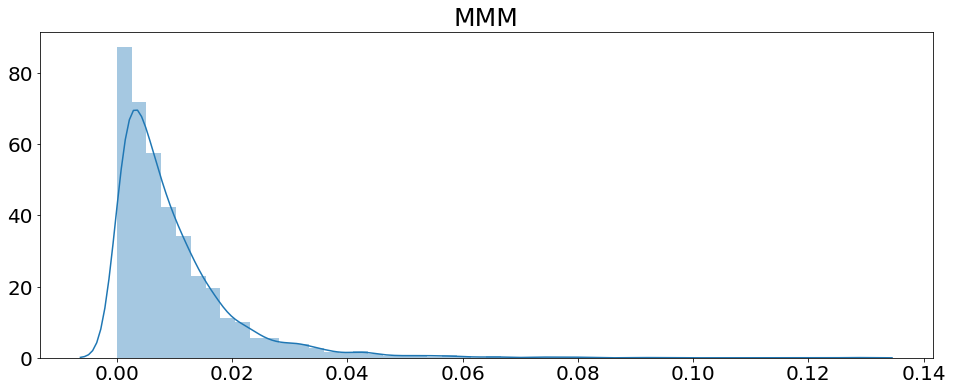

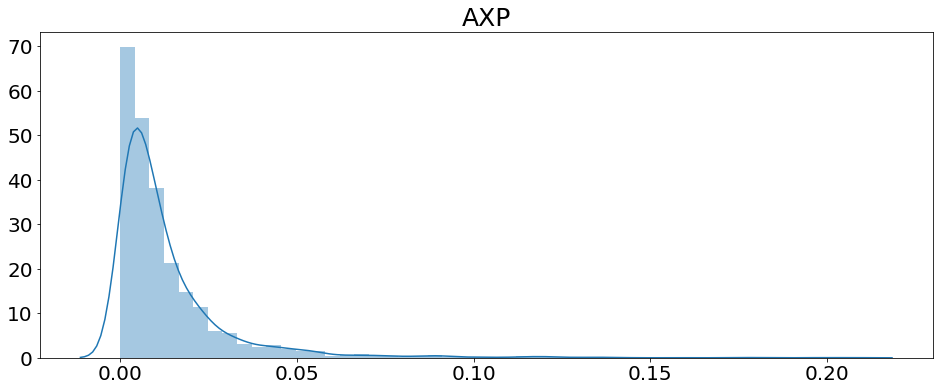

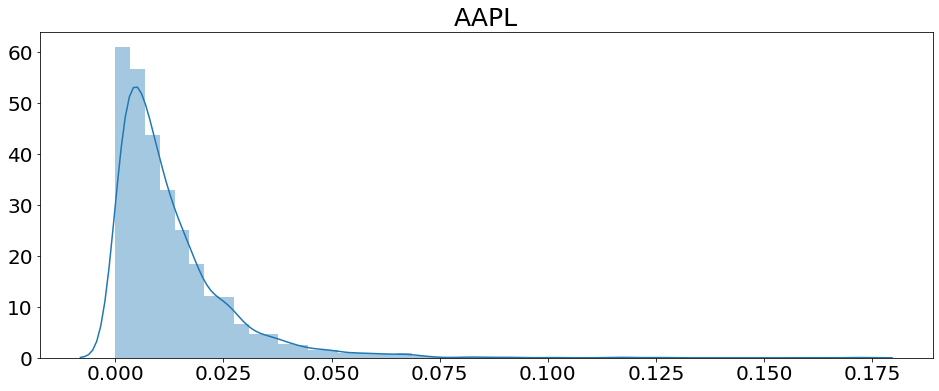

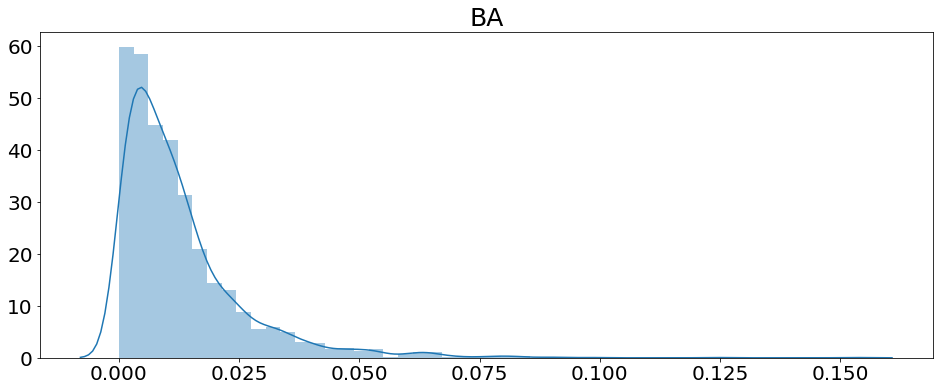

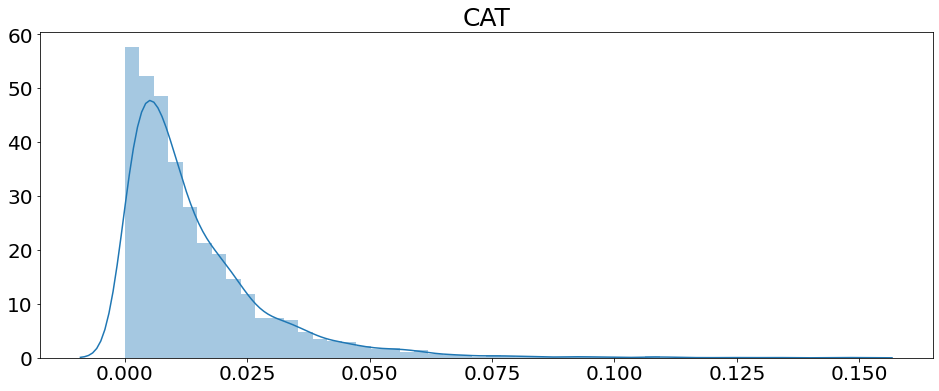

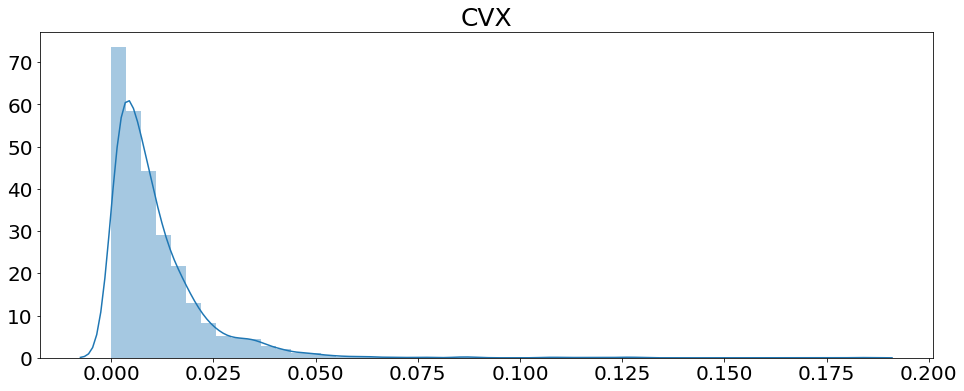

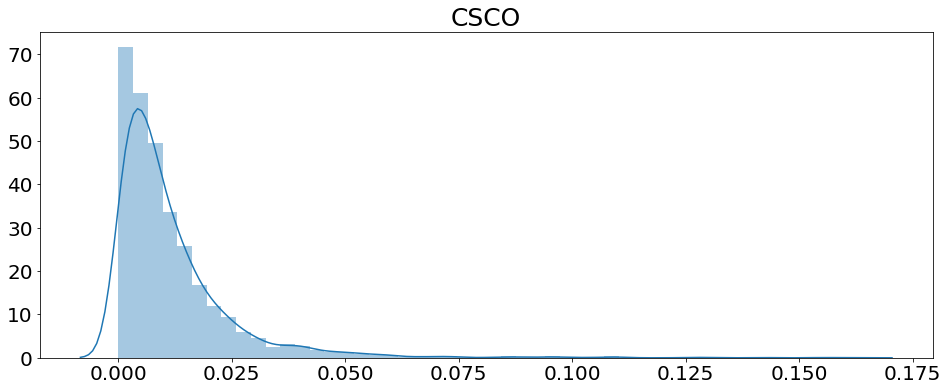

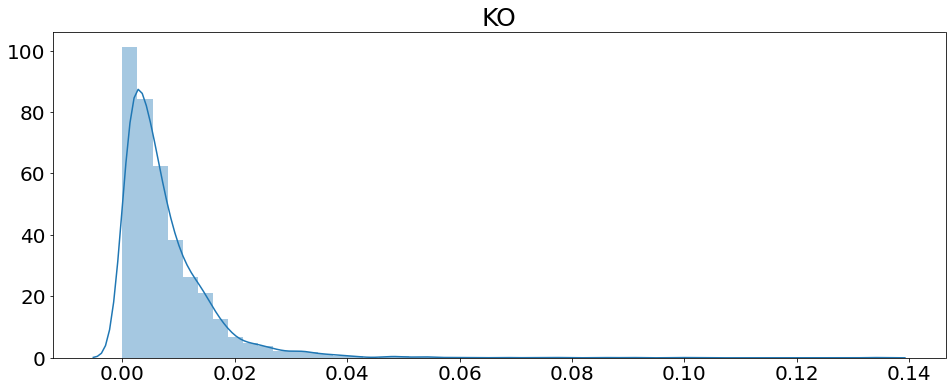

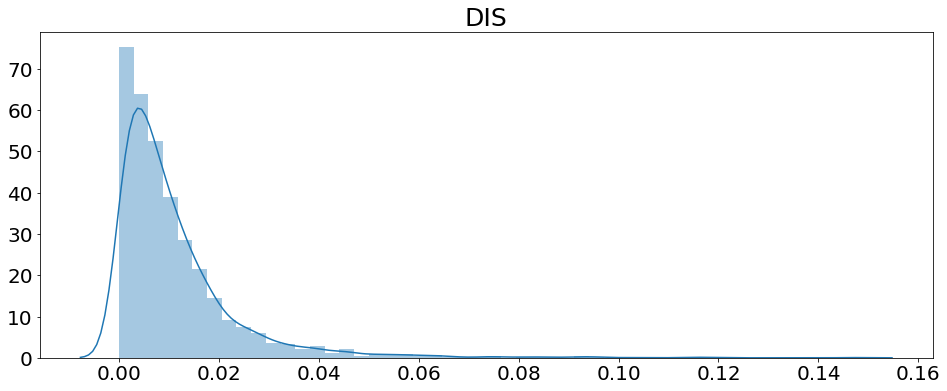

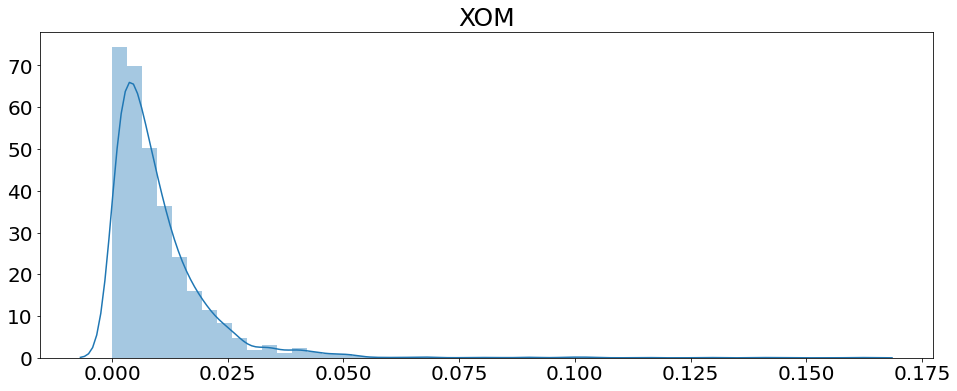

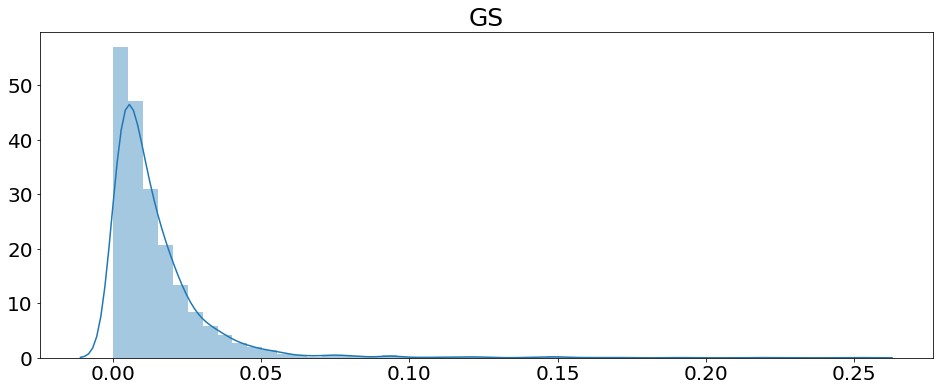

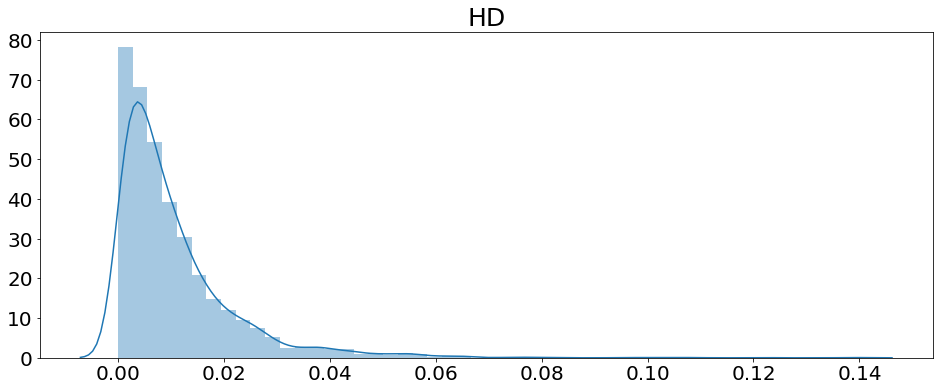

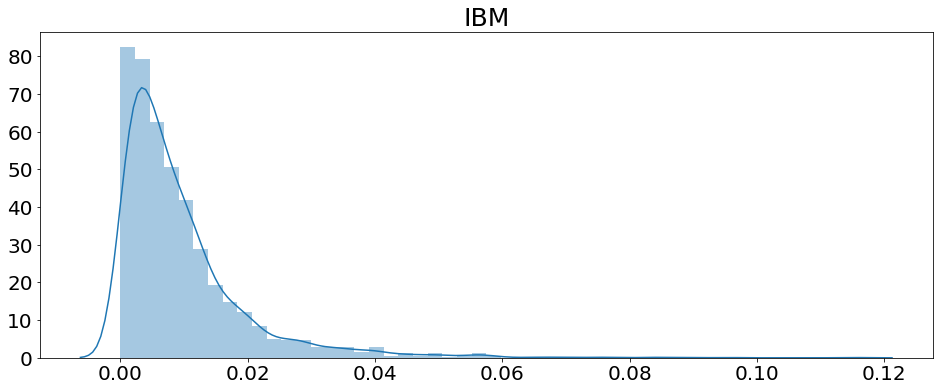

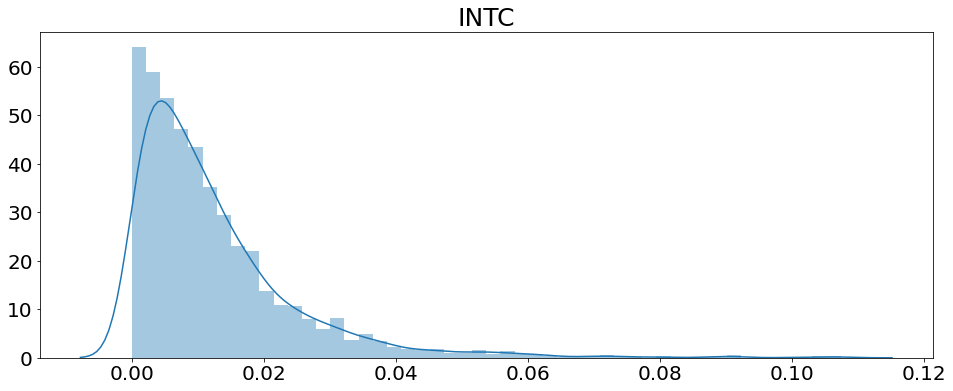

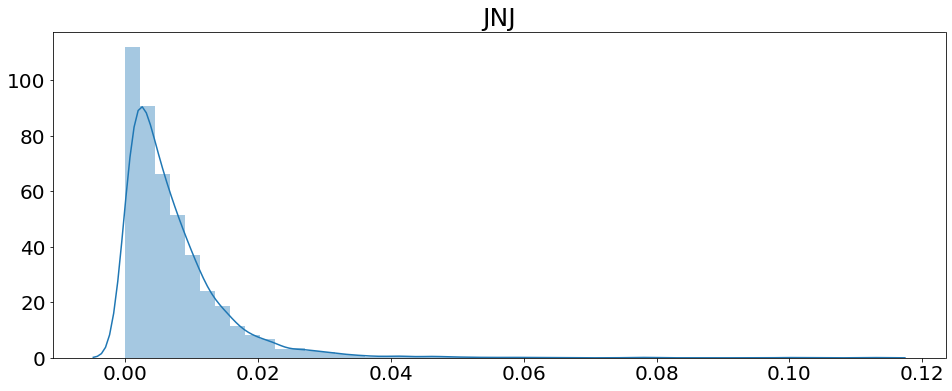

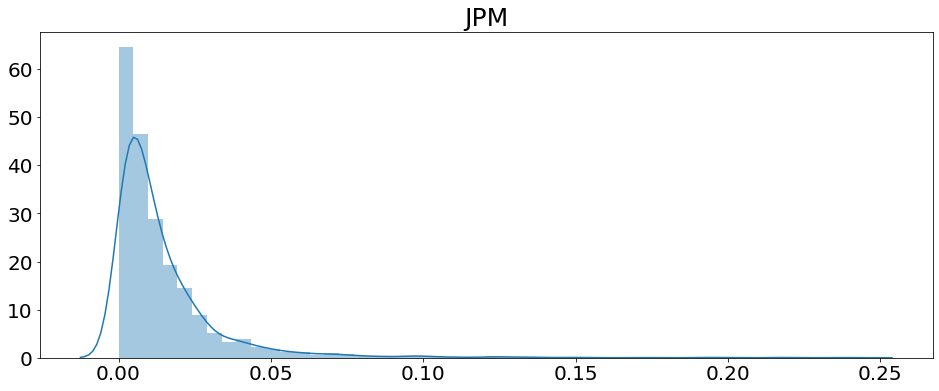

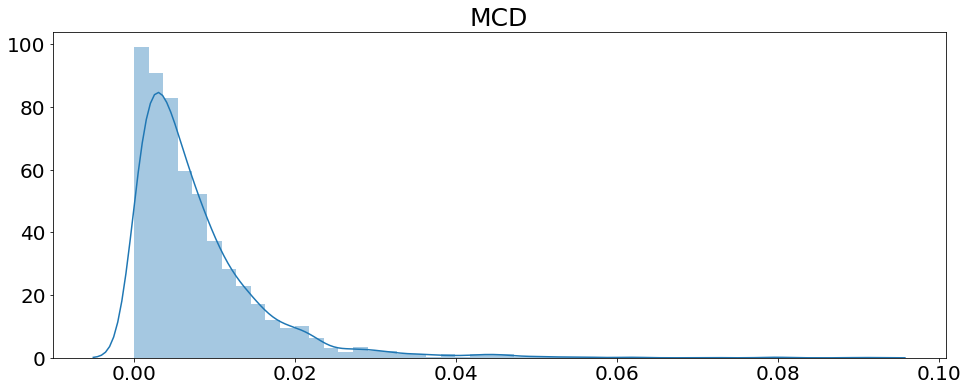

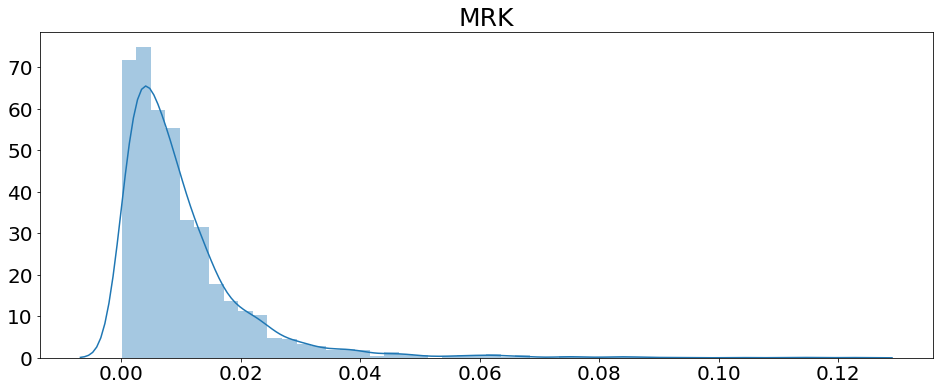

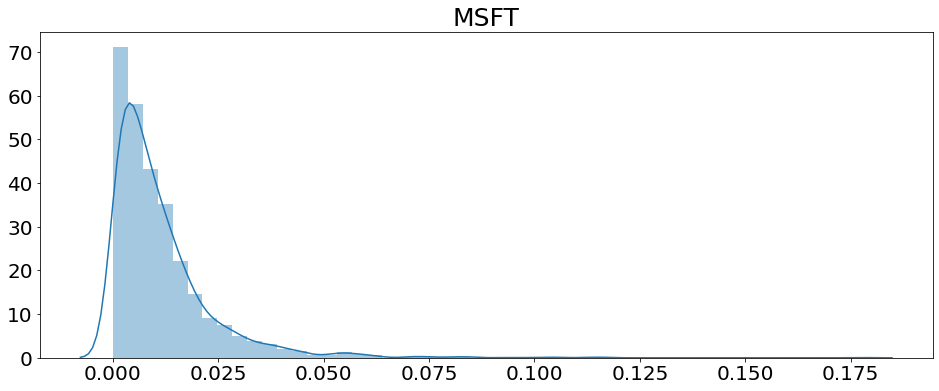

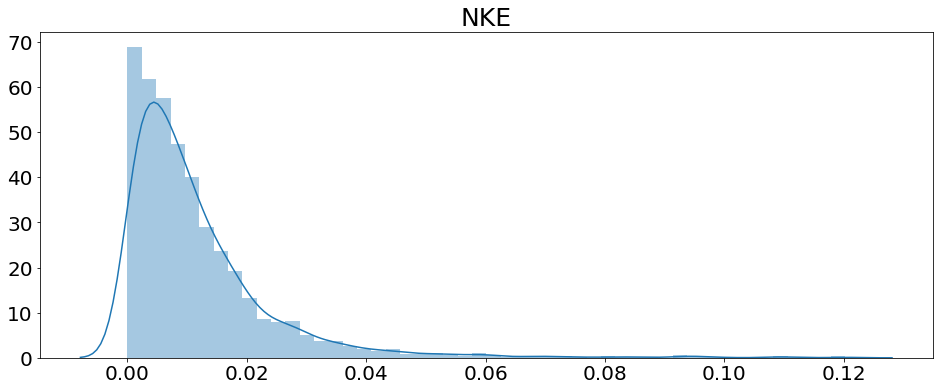

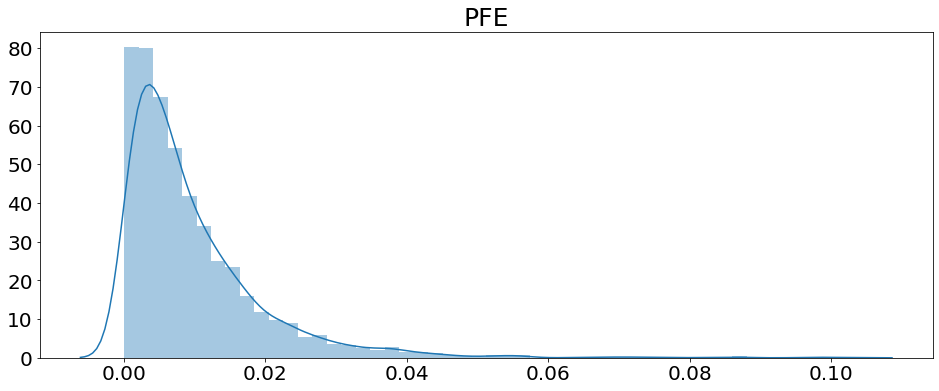

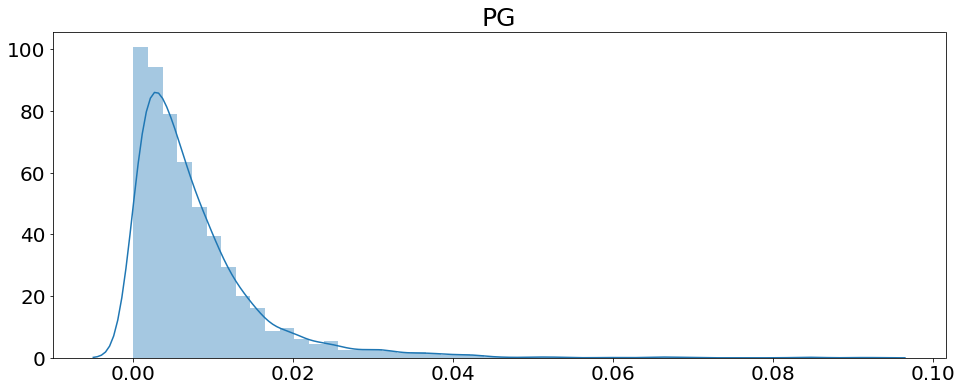

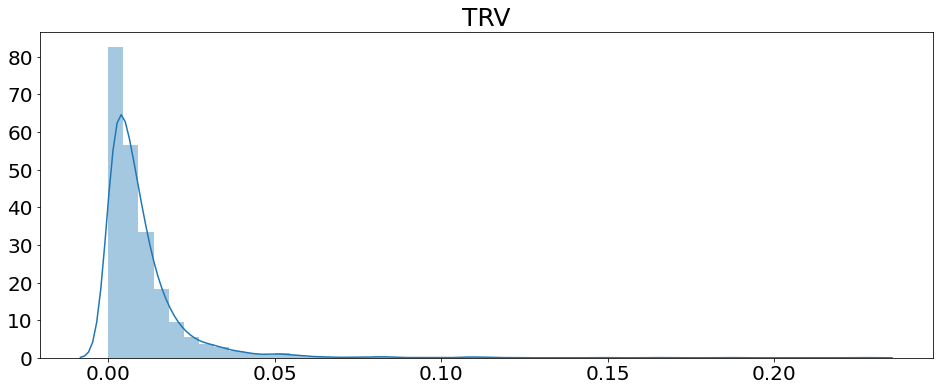

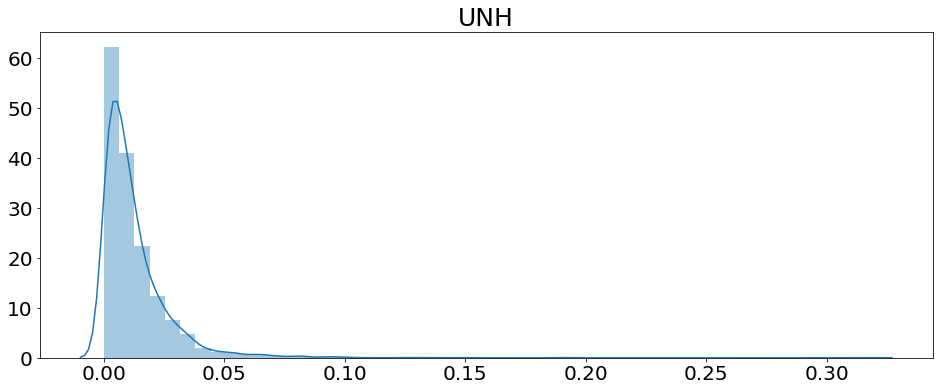

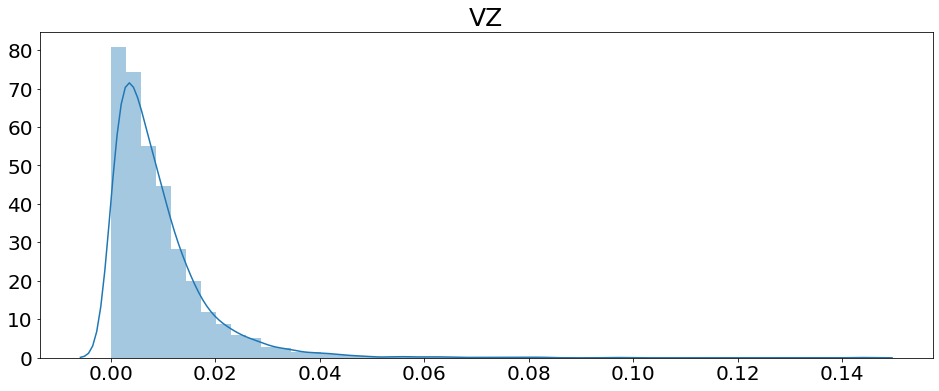

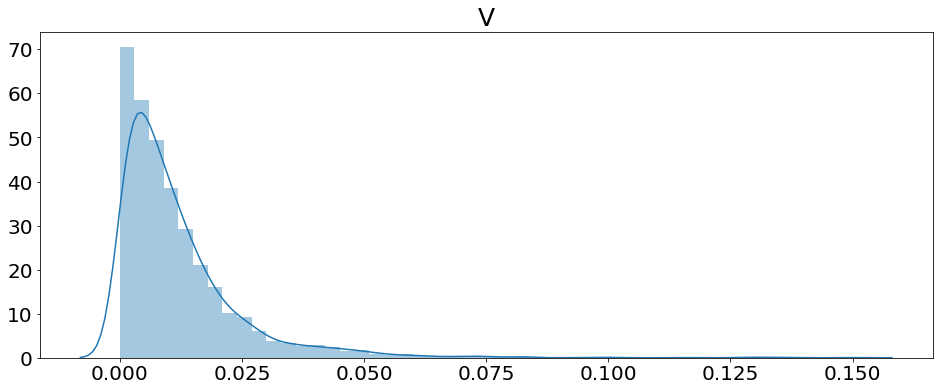

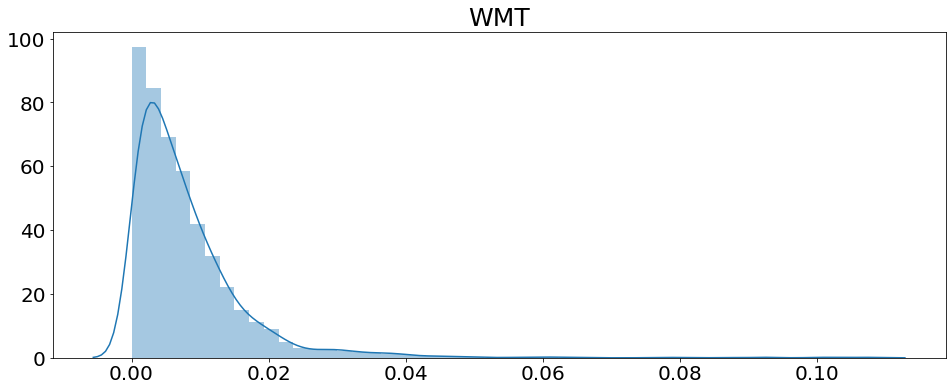

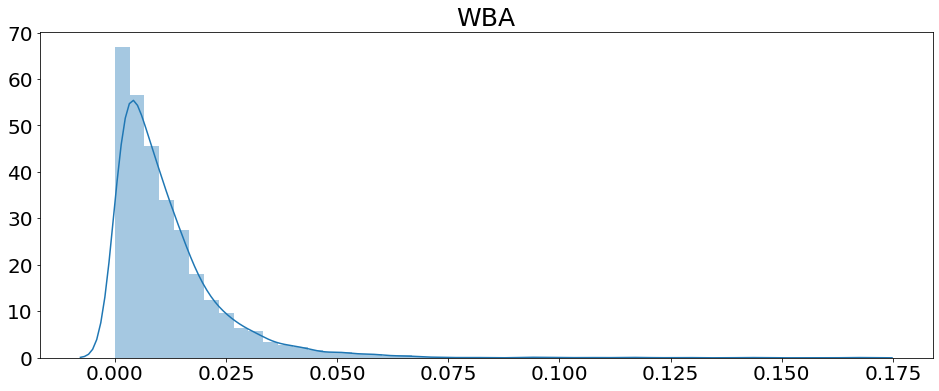

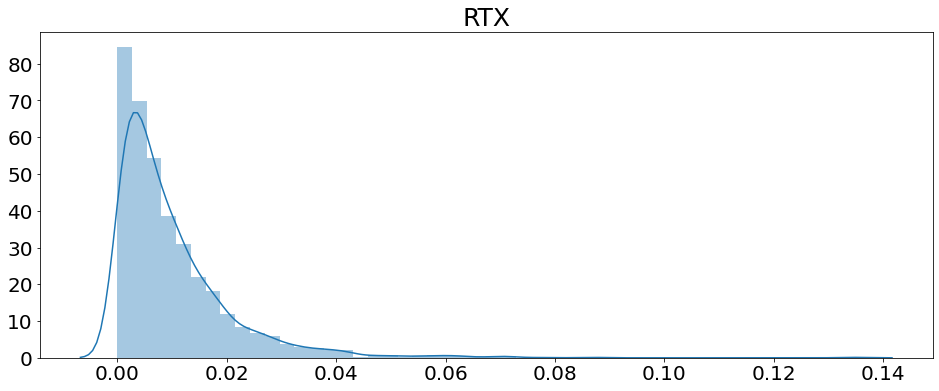

In [ ]:
for i in range(len(stock_id2)): 
# for i in range(1):    
  fig = plt.figure(figsize = (16,6))
  sns.distplot(globals()['train_mse_loss_{}'.format(stock_id2[i])], bins=50);
  plt.ylabel('')
  plt.xticks(fontsize = 20)
  plt.yticks(fontsize = 20)
  plt.title(stock_id2[i], fontsize = 25)
  plt.savefig('fig/train_mse/'+ stock_id2[i]+'.png', dpi=300, bbox_inches='tight') 
  # plt.savefig('fig/train_mse/'+ stock_id2[i]+'.eps', dpi=300)
  plt.show()

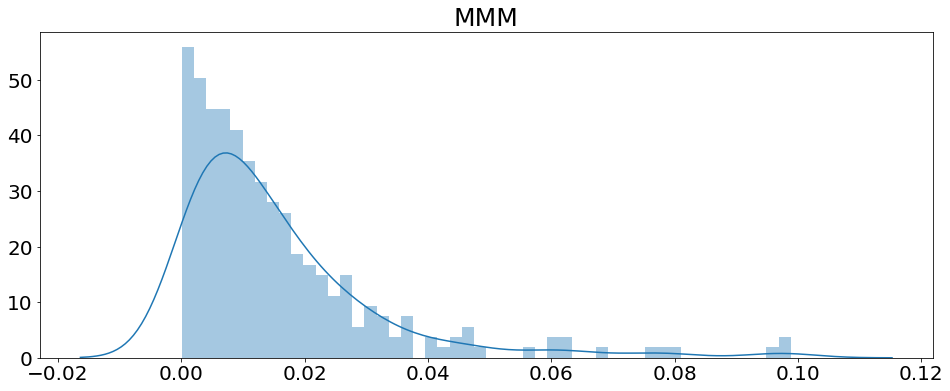

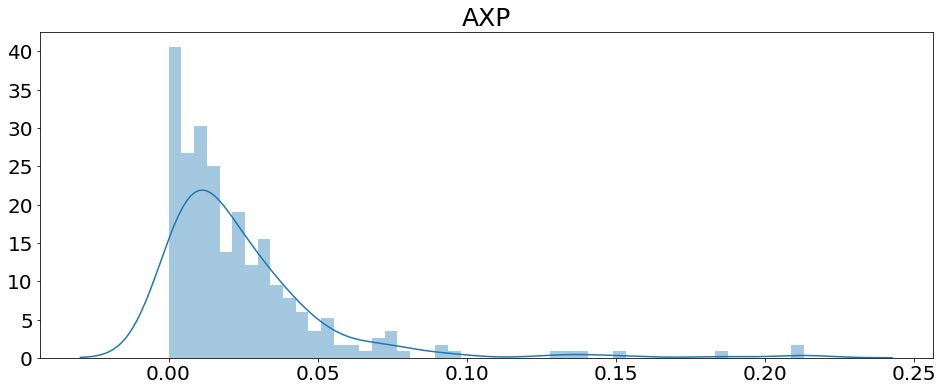

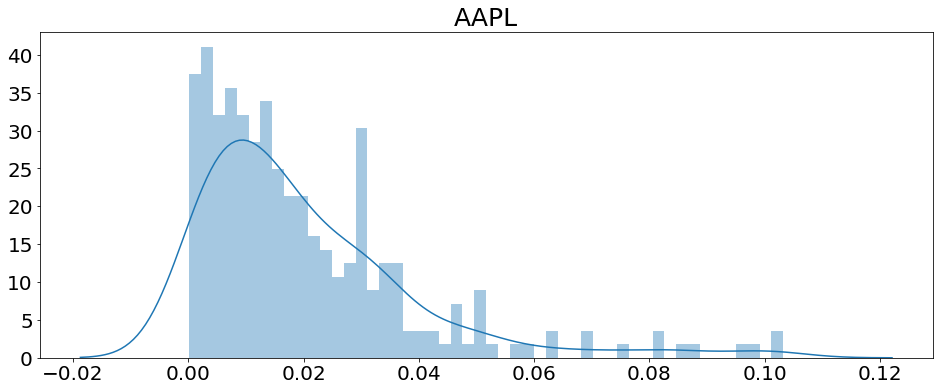

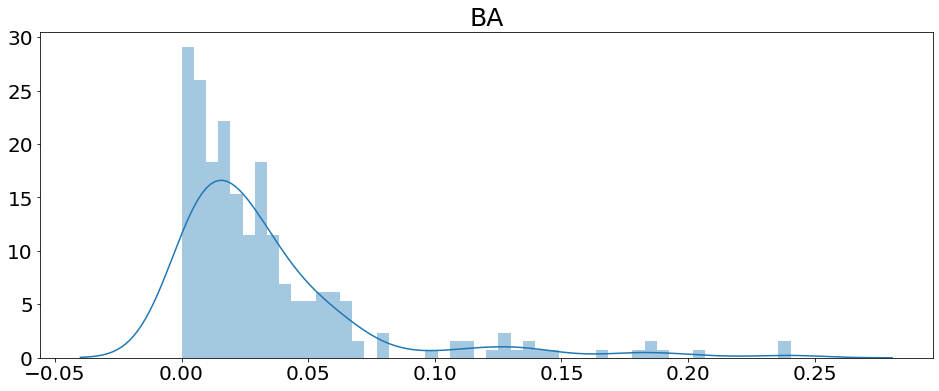

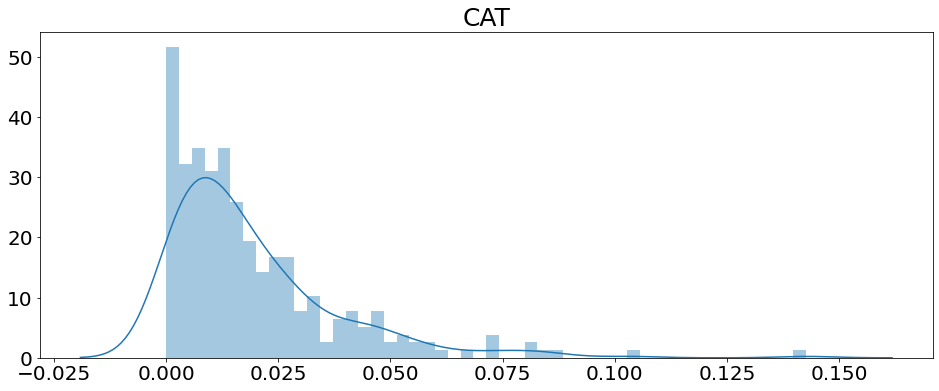

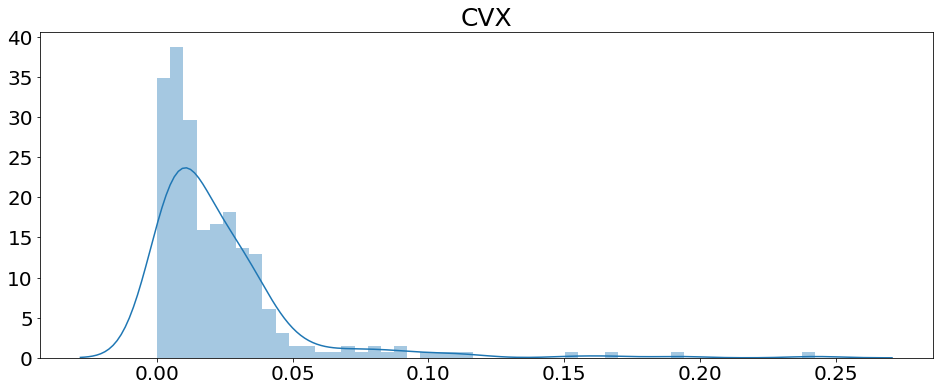

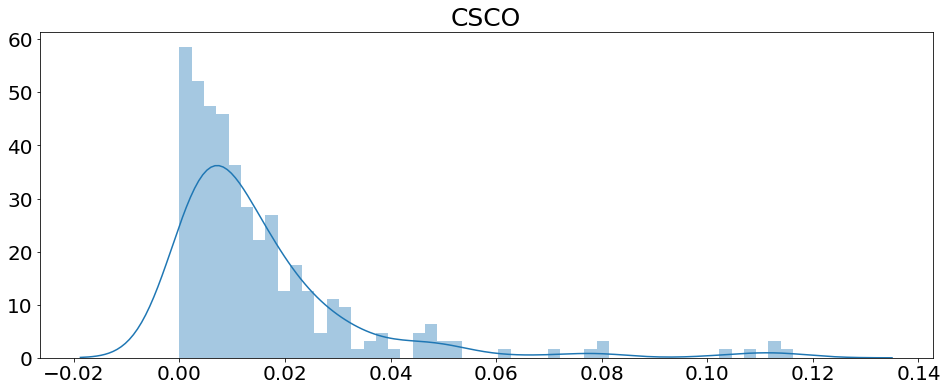

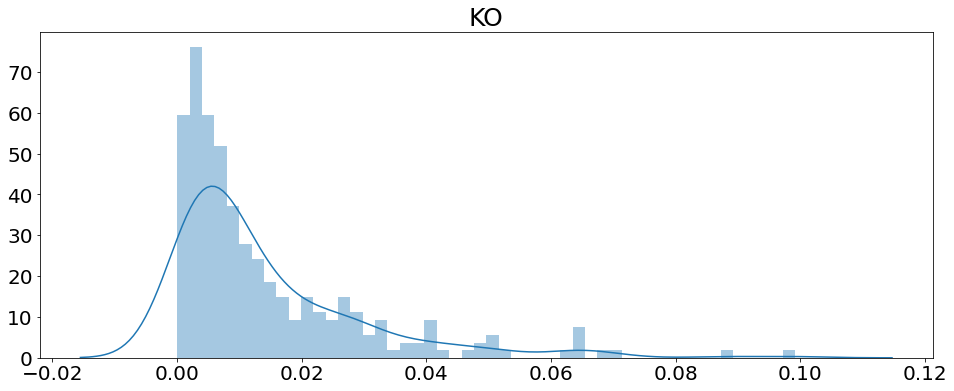

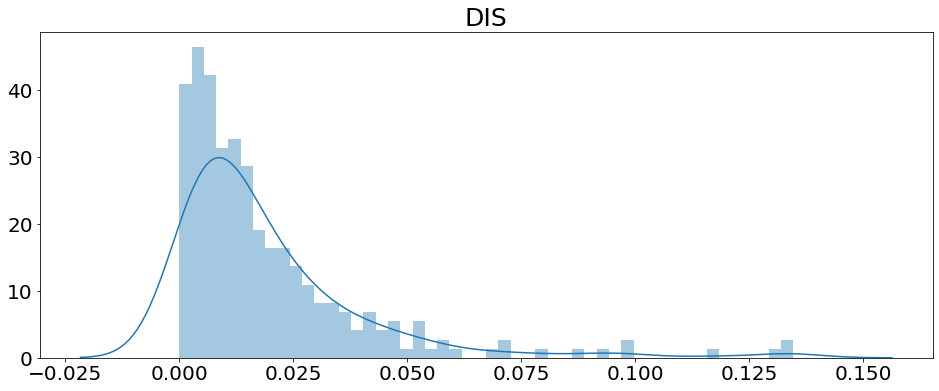

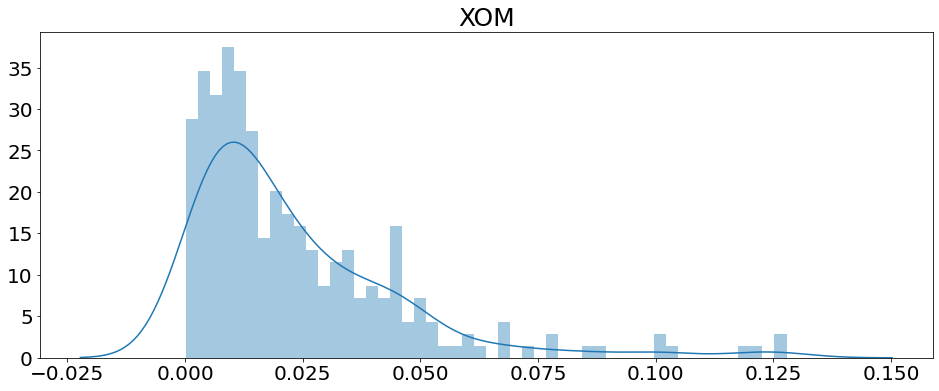

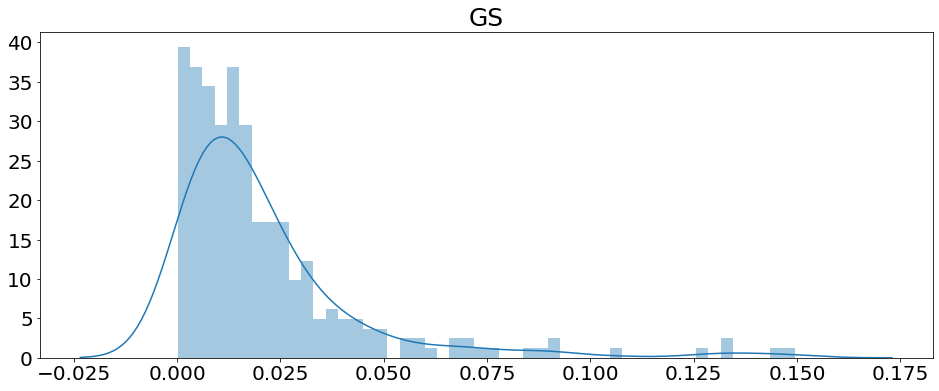

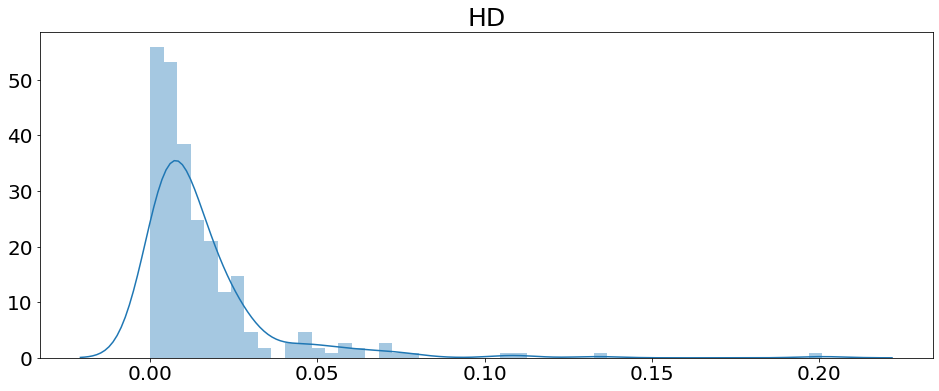

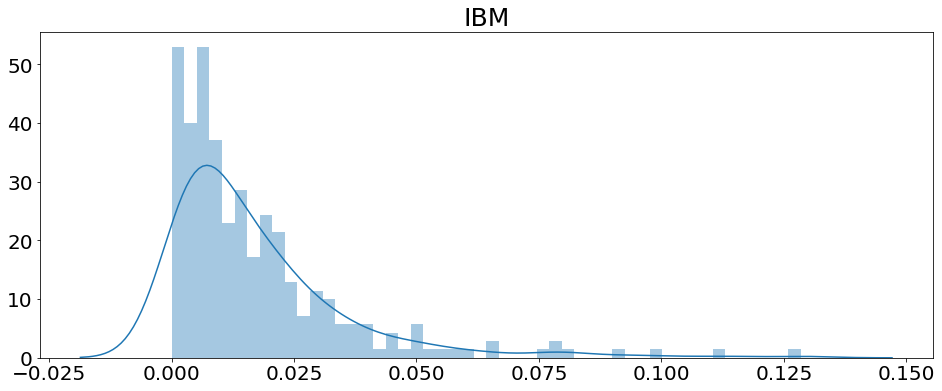

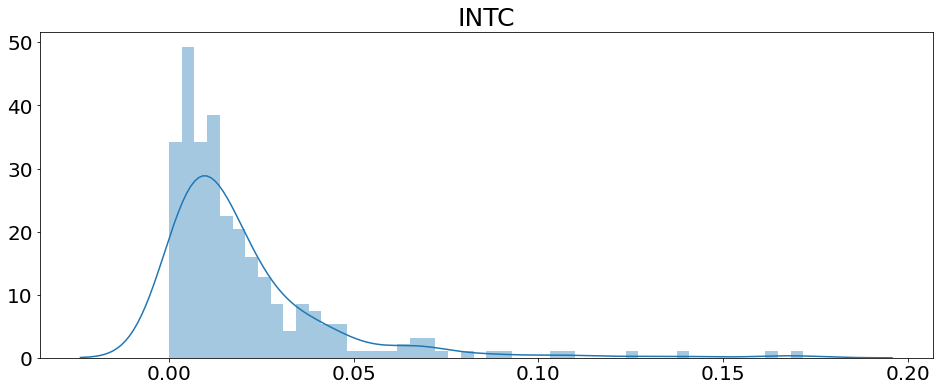

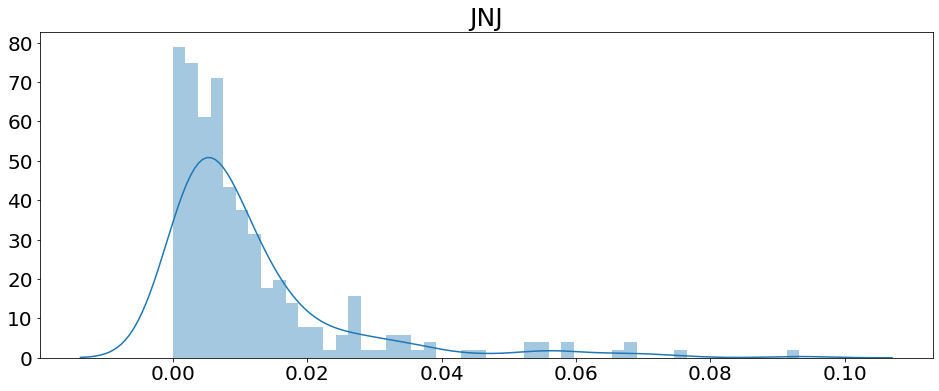

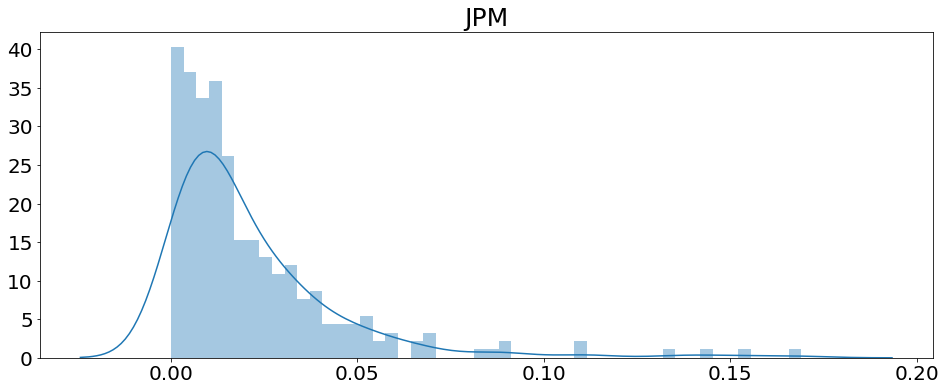

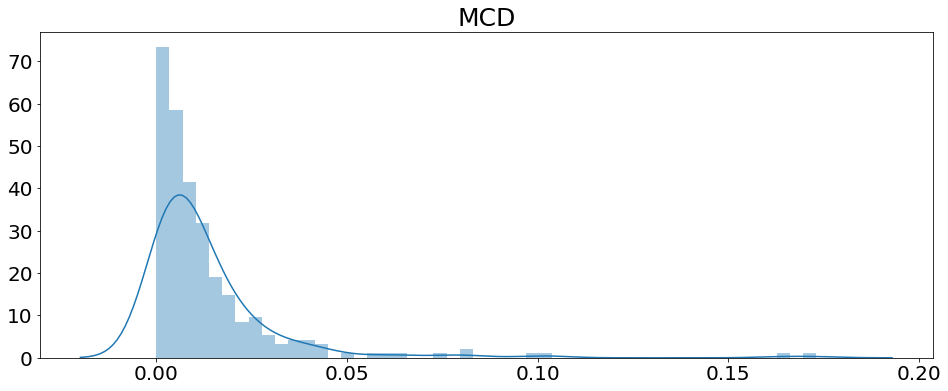

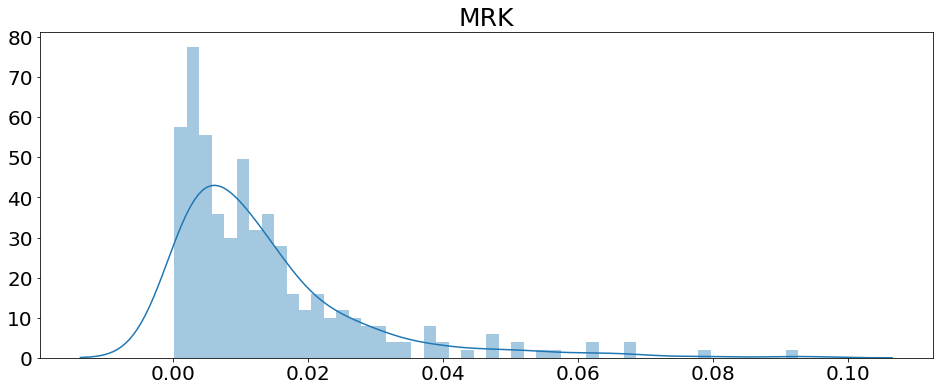

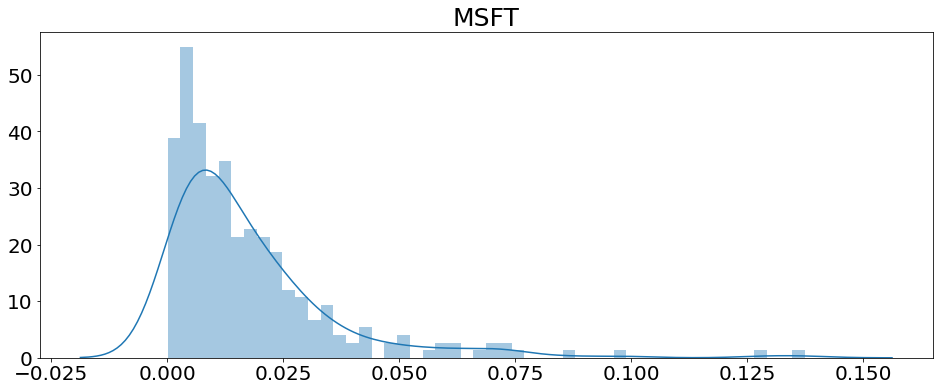

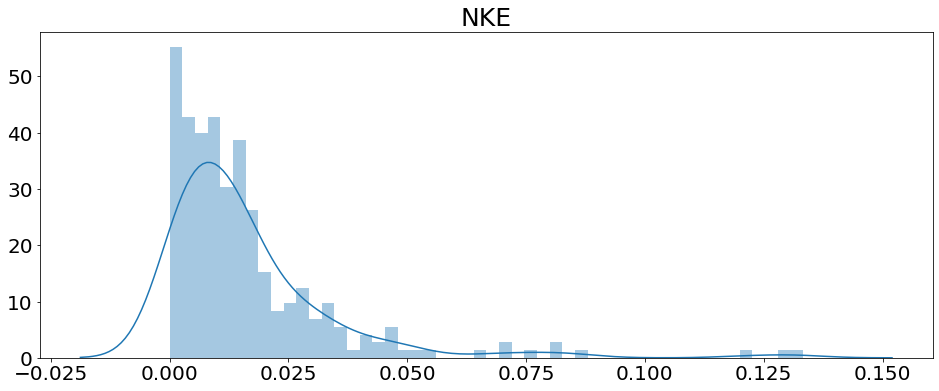

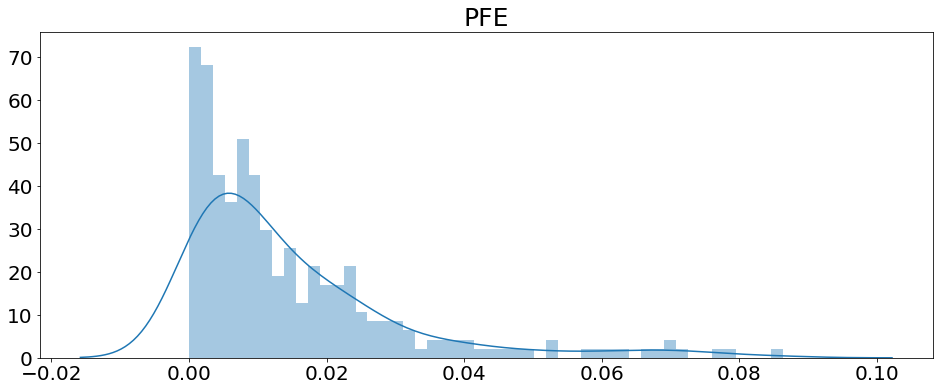

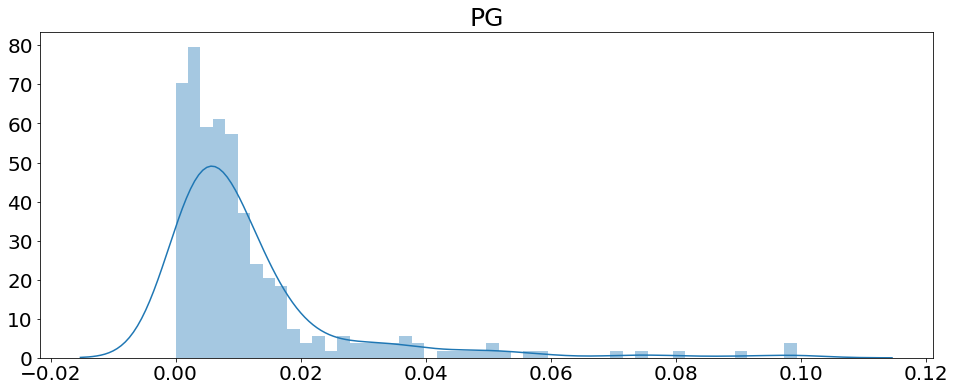

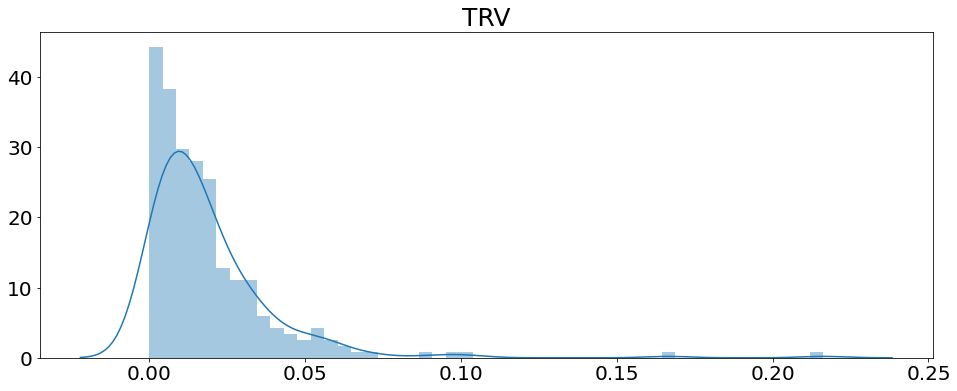

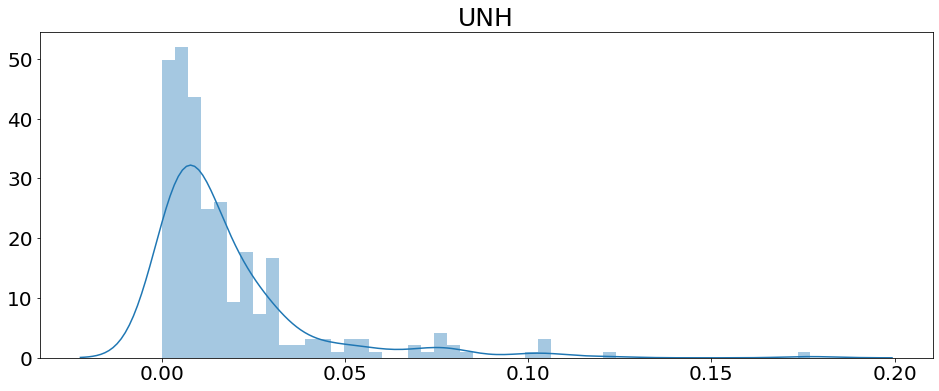

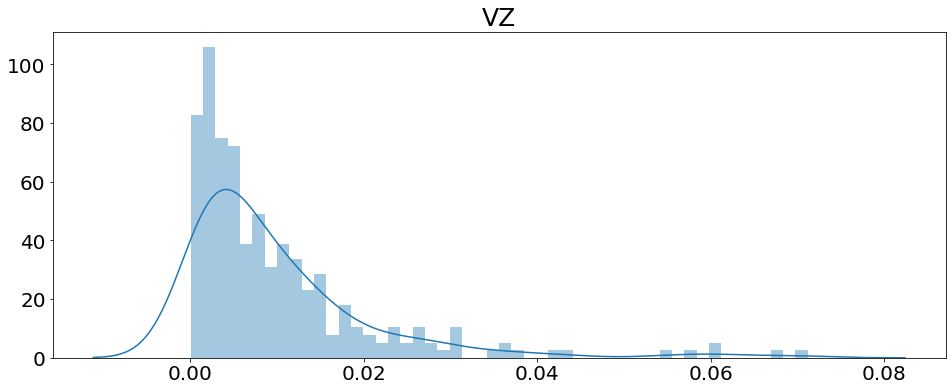

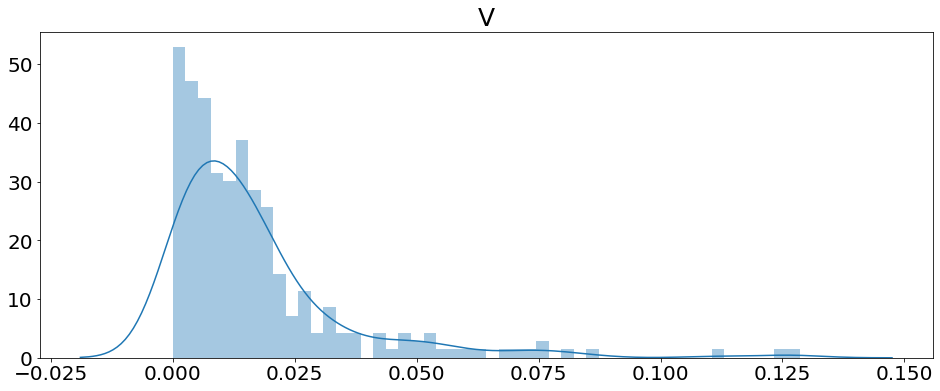

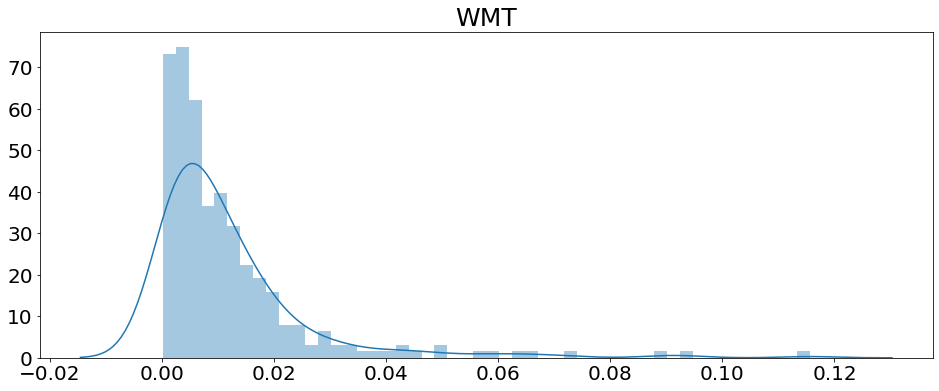

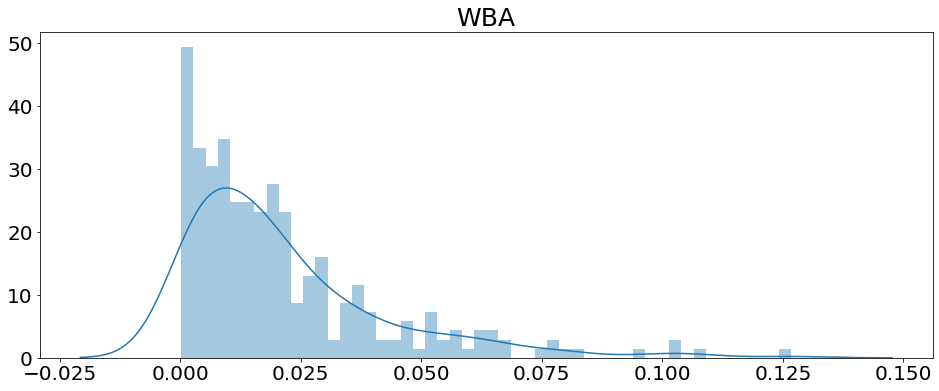

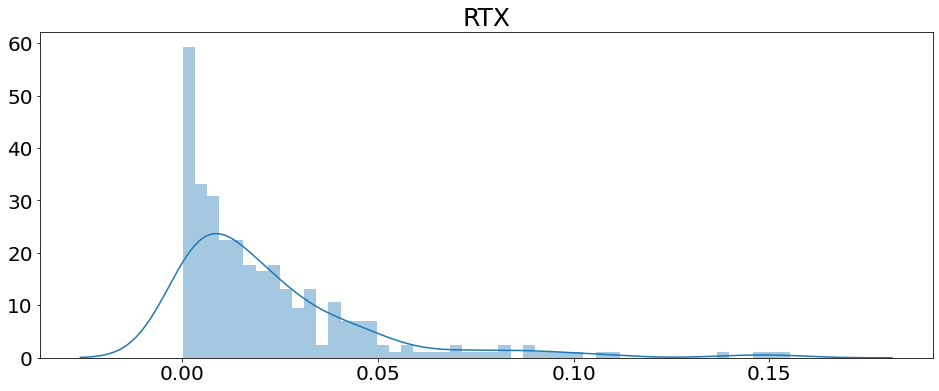

In [ ]:
for i in range(len(stock_id2)): 
# for i in range(1):    
  fig = plt.figure(figsize = (16,6))
  sns.distplot(globals()['test_mse_loss_{}'.format(stock_id2[i])], bins=50);
  plt.xticks(fontsize = 20)
  plt.yticks(fontsize = 20)
  plt.ylabel('')
  plt.title(stock_id2[i], fontsize = 25)
  plt.savefig('fig/test_mse/'+ stock_id2[i]+'.png', dpi=300) 
  # plt.savefig('fig/test_mse/'+ stock_id2[i]+'.eps', dpi=300)
  plt.show()

In [ ]:
# for i in range(len(stock_id2)): 

#   q25, q75 = np.quantile(globals()['train_mse_loss_{}'.format(stock_id2[i])], 0.25), np.quantile(globals()['train_mse_loss_{}'.format(stock_id2[i])], 0.75)          
#   iqr = q75 - q25    
#   cut_off = iqr * 1.5          
#   lower, upper = q25 - cut_off, q75 + cut_off

#   globals()['threshold_{}'.format(stock_id2[i])] = upper

In [32]:
for i in range(len(stock_id2)): 
# for i in range(1):  
    globals()['threshold_{}'.format(stock_id2[i])] = np.quantile(globals()['train_mse_loss_{}'.format(stock_id2[i])], 0.99)

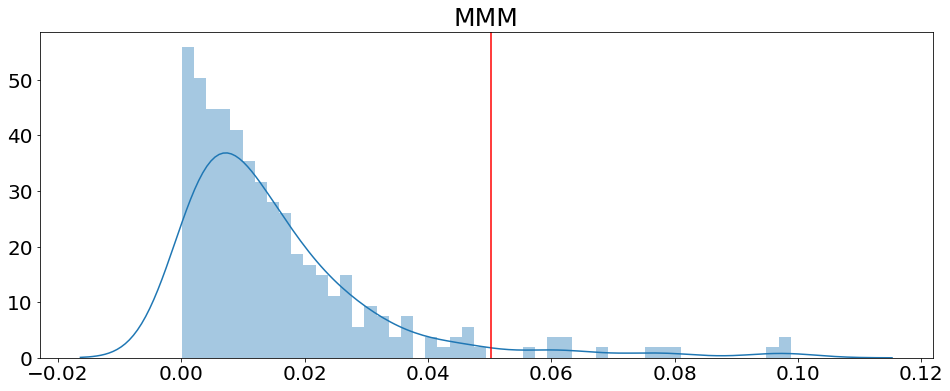

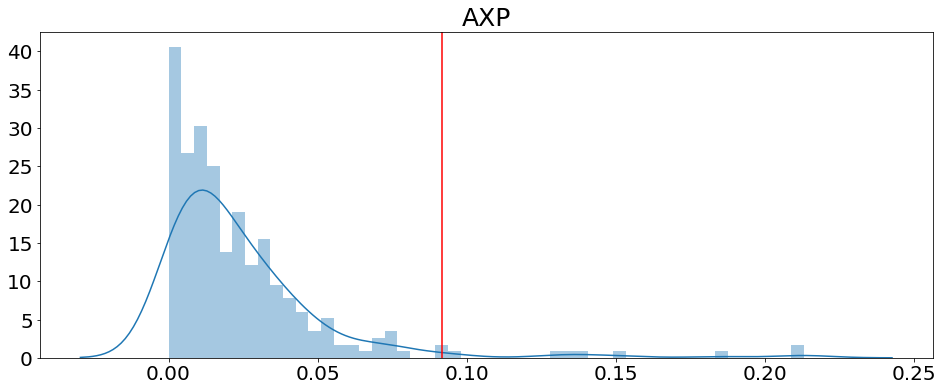

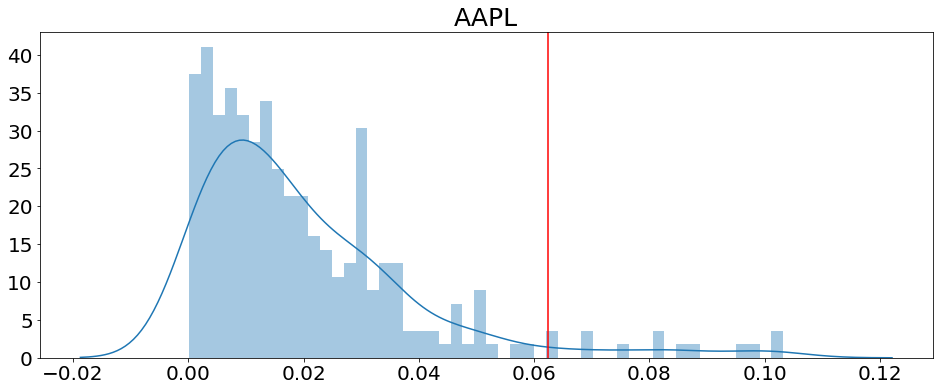

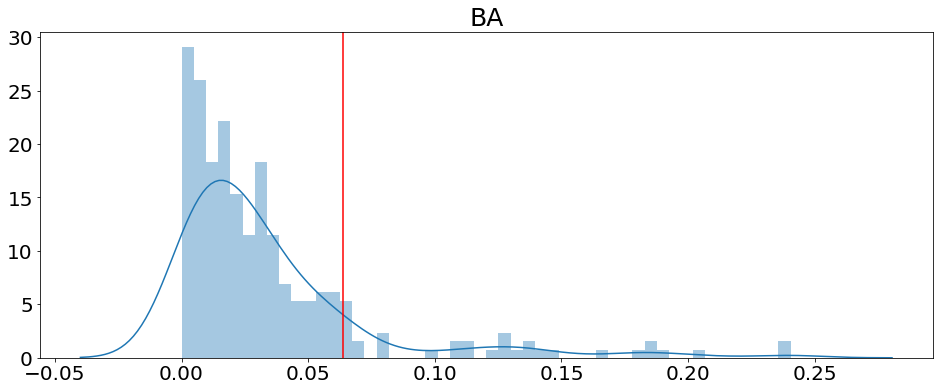

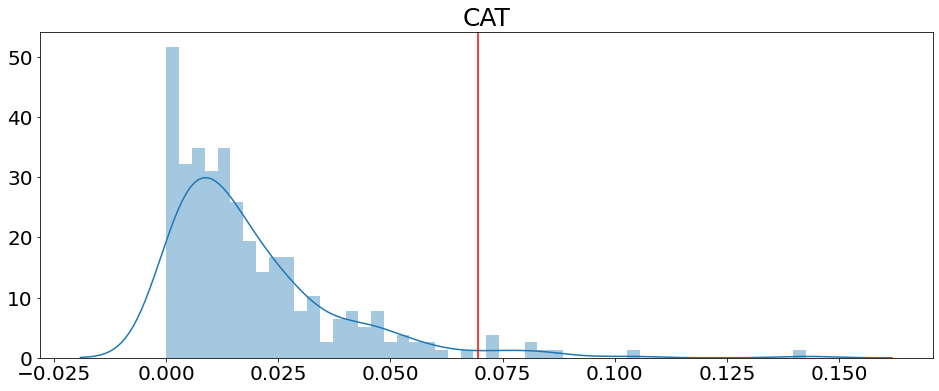

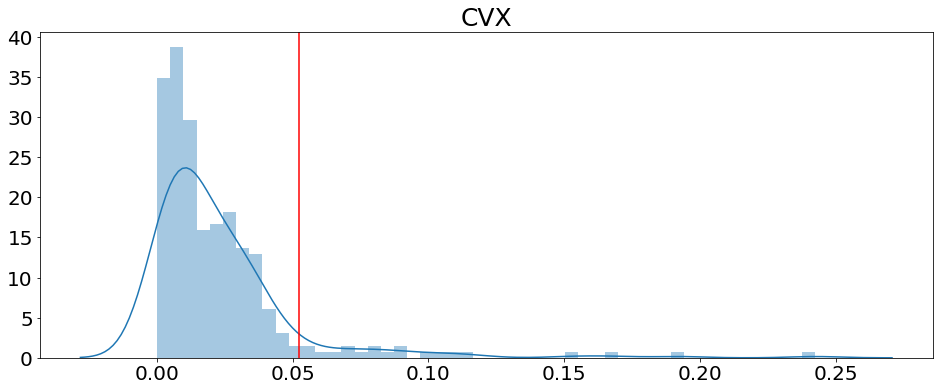

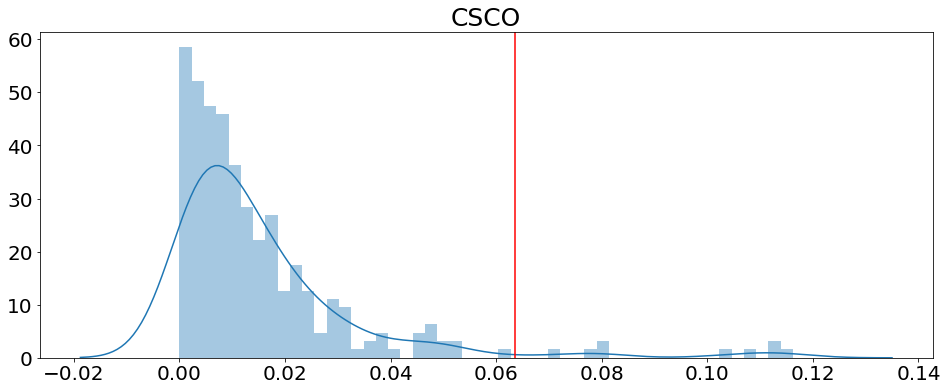

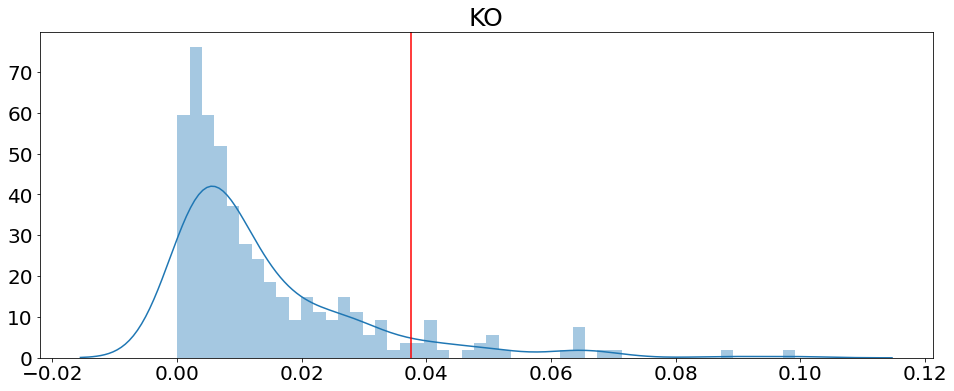

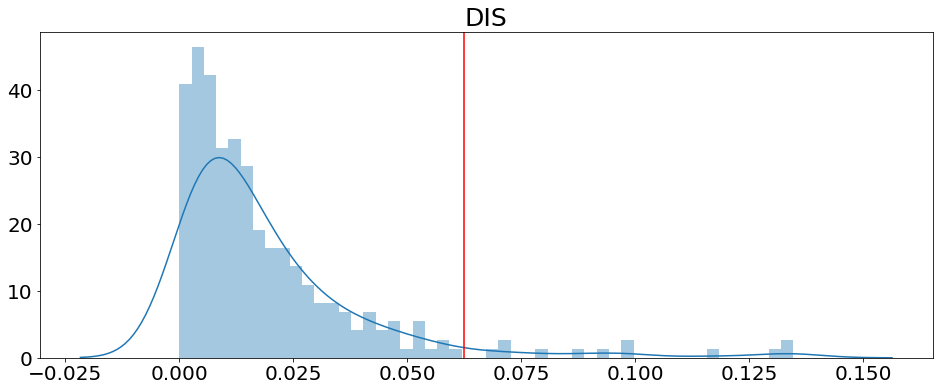

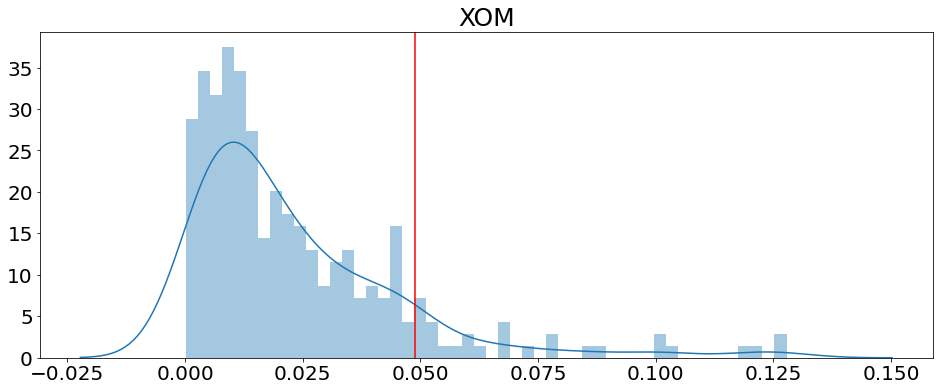

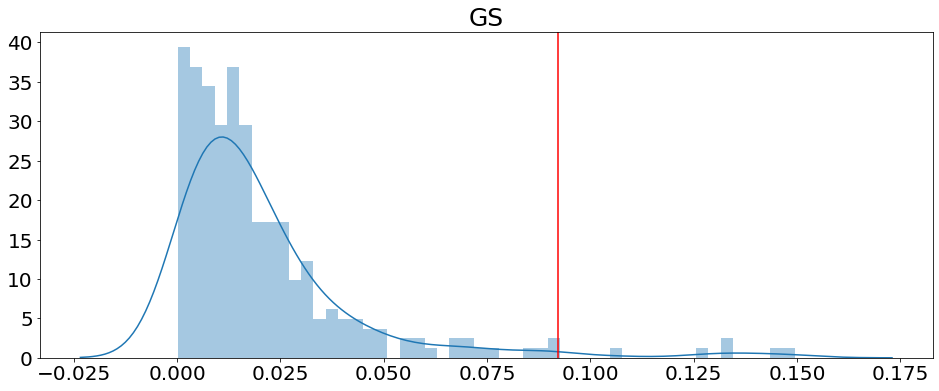

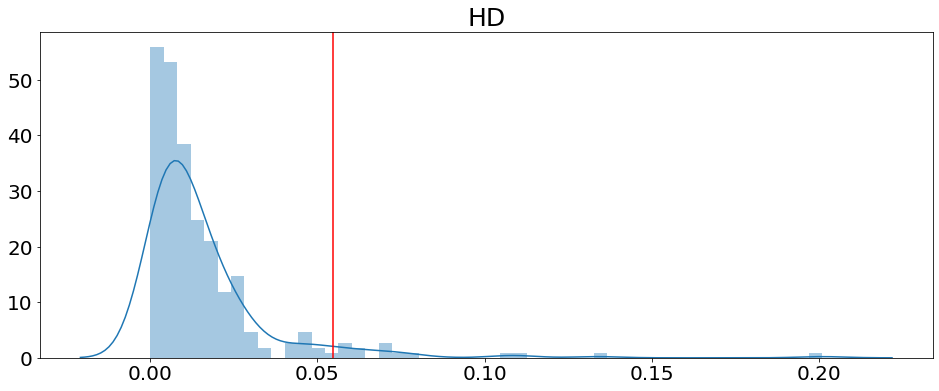

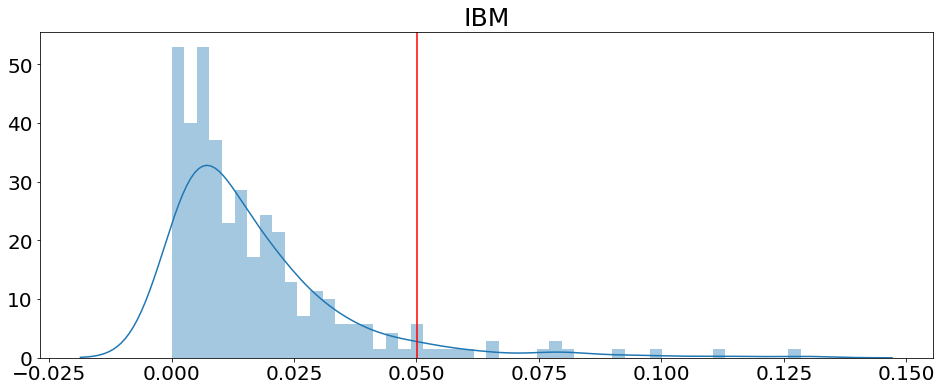

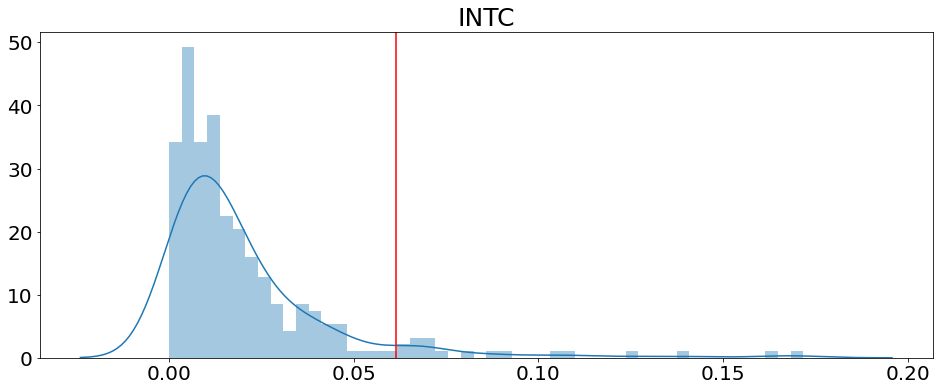

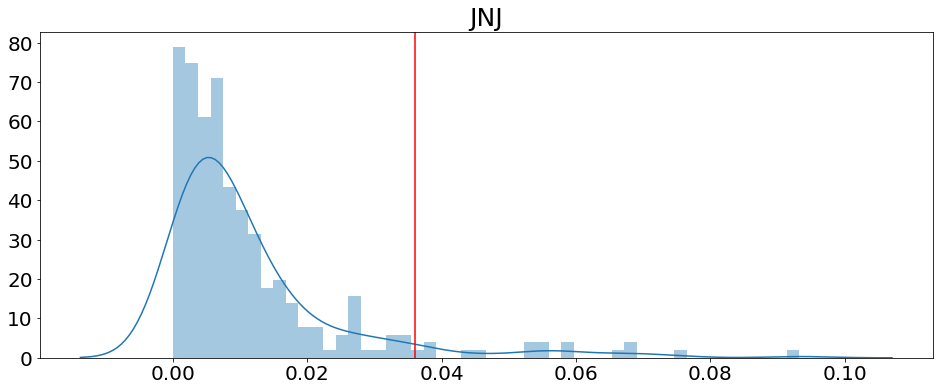

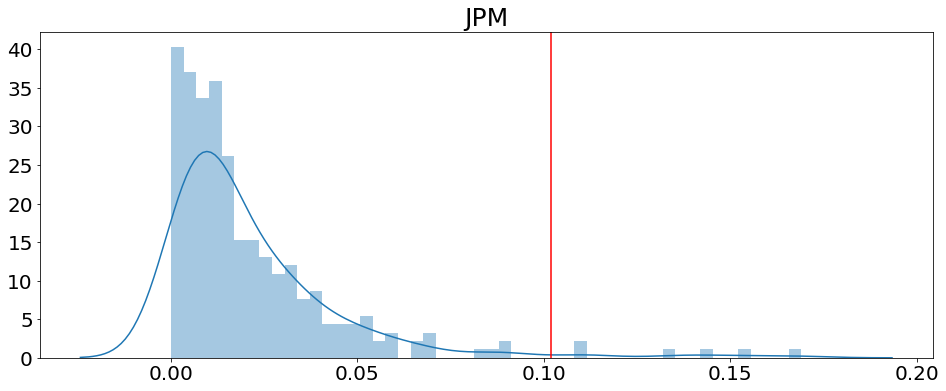

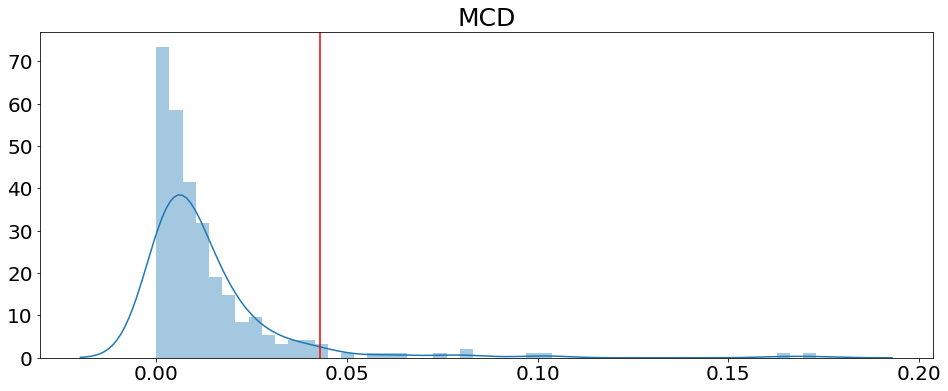

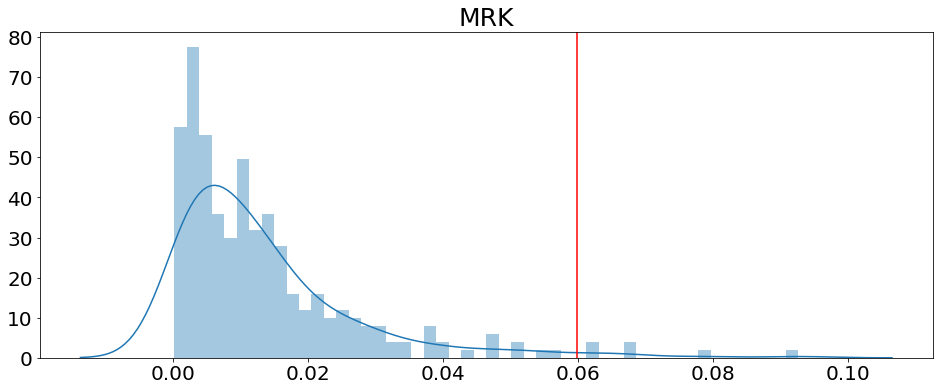

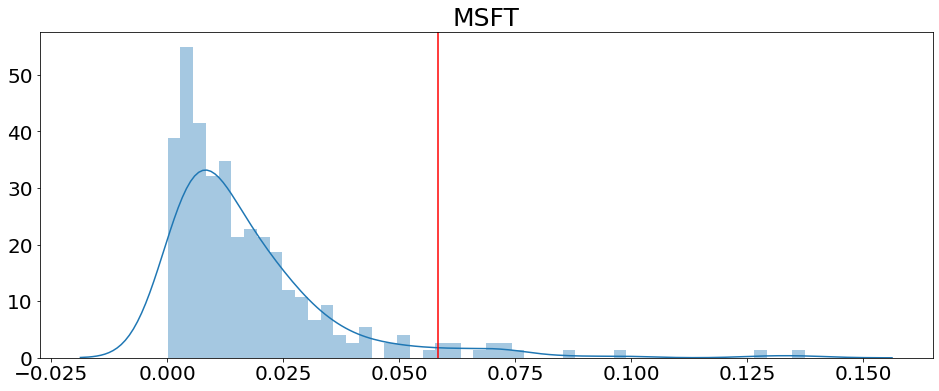

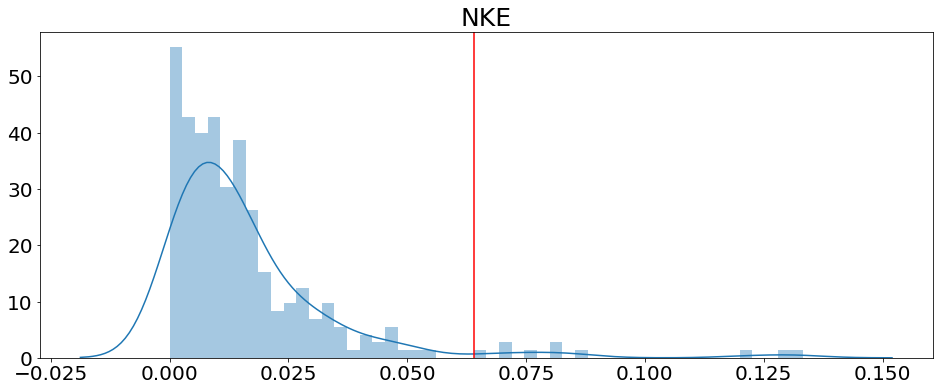

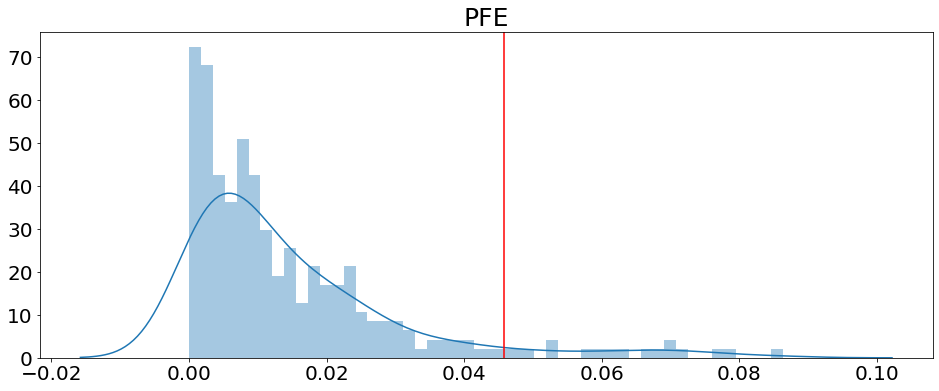

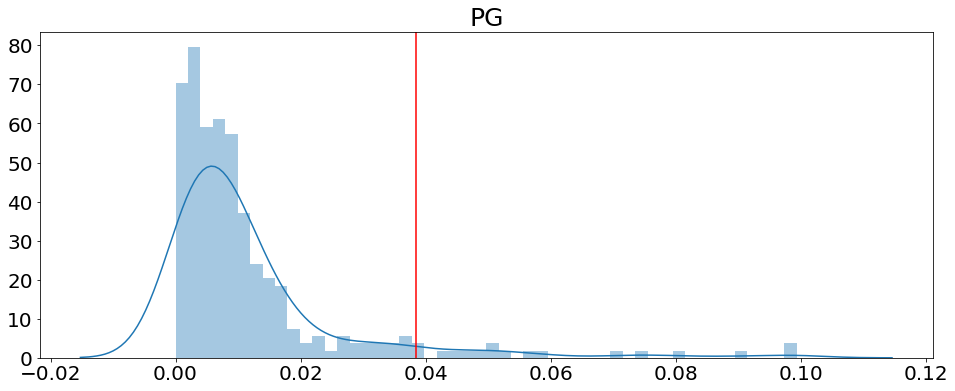

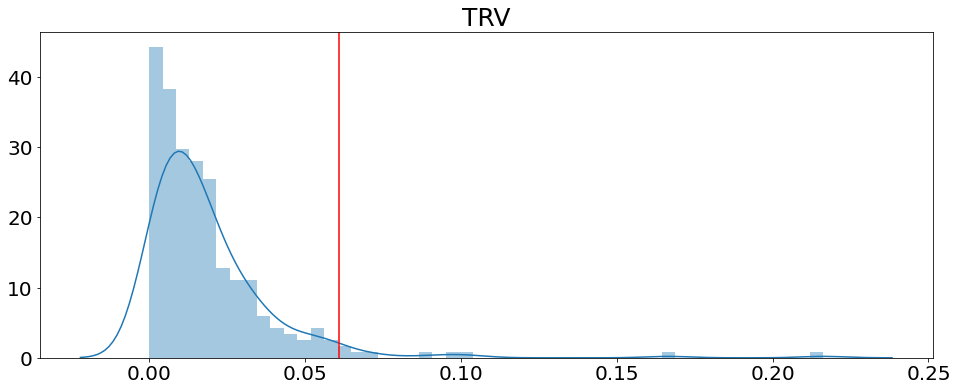

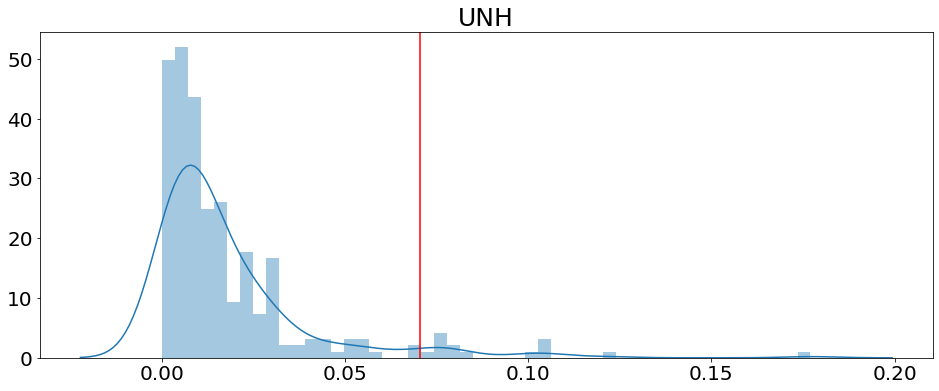

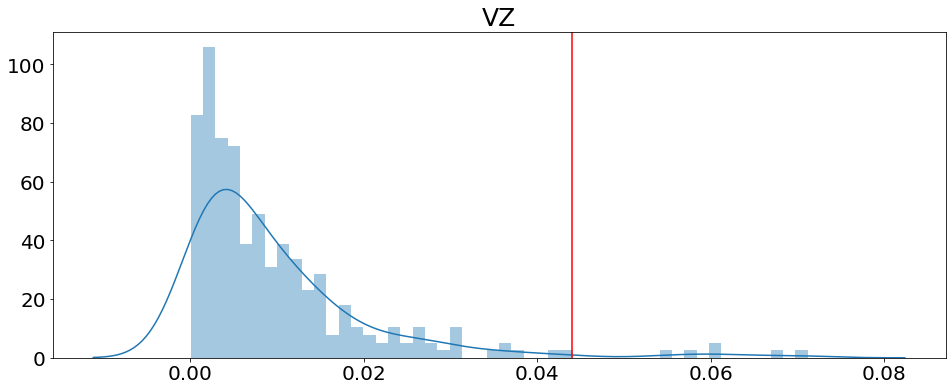

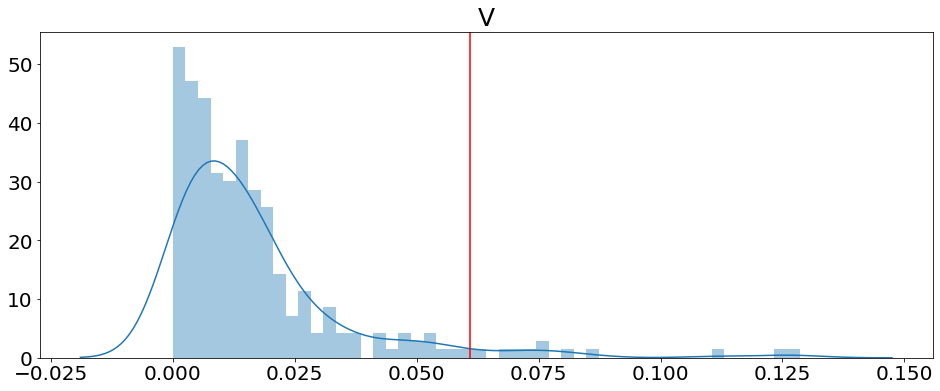

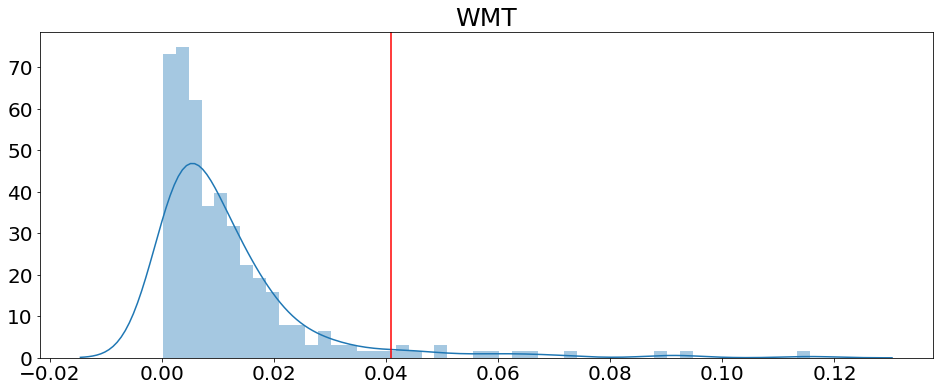

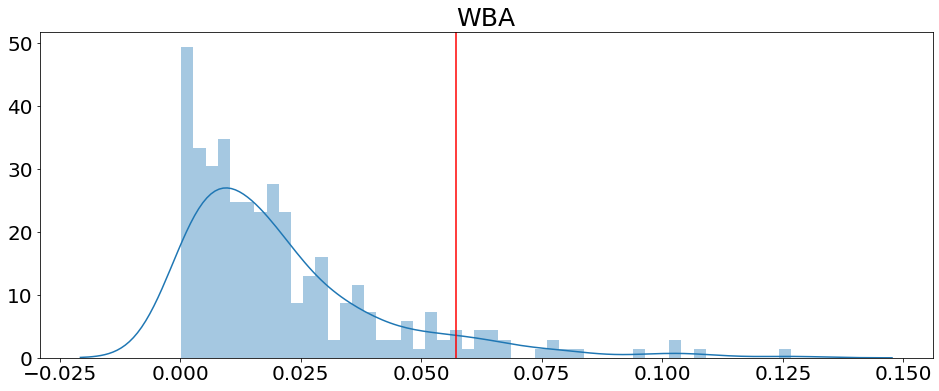

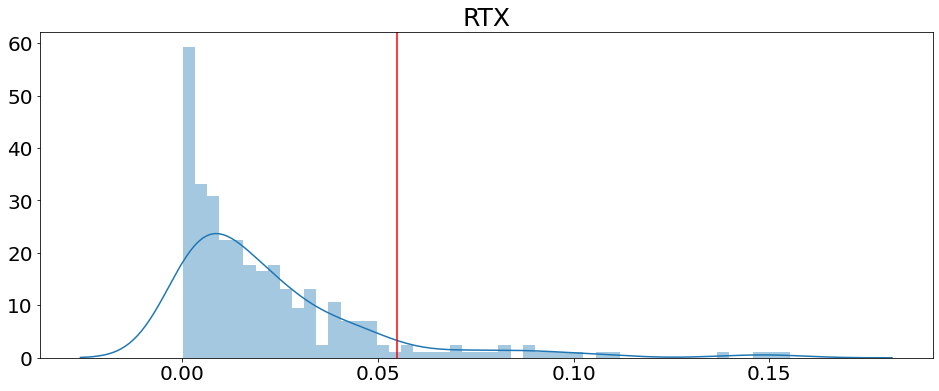

In [ ]:
for i in range(len(stock_id2)): 
# for i in range(1):    
  fig = plt.figure(figsize = (16,6))
  sns.distplot(globals()['test_mse_loss_{}'.format(stock_id2[i])], bins=50);
  plt.xticks(fontsize = 20)
  plt.yticks(fontsize = 20)
  plt.ylabel('')
  plt.axvline(x=globals()['threshold_{}'.format(stock_id2[i])], label='Threshold', color='red')

  plt.title(stock_id2[i], fontsize = 25)
  plt.savefig('fig/test_mse2/'+ stock_id2[i]+'.png', dpi=300, bbox_inches='tight') 
  # plt.savefig('fig/test_mse2/'+ stock_id2[i]+'.eps', dpi=300)
  plt.show()

In [33]:
for i in range(len(stock_id2)): 
# for i in range(1):    
  # test_score_MMM,...,test_score_RTX
  globals()['test_score_{}'.format(stock_id2[i])]= pd.DataFrame(index=test[TIME_STEPS:].index)
  globals()['test_score_{}'.format(stock_id2[i])]['loss'] = globals()['test_mse_loss_{}'.format(stock_id2[i])]
  globals()['test_score_{}'.format(stock_id2[i])]['threshold'] = globals()['threshold_{}'.format(stock_id2[i])]
  globals()['test_score_{}'.format(stock_id2[i])]['anomaly'] = globals()['test_score_{}'.format(stock_id2[i])].loss >= globals()['test_score_{}'.format(stock_id2[i])].threshold
  globals()['test_score_{}'.format(stock_id2[i])]['return'] = df_test[[stock_id2[i]]][TIME_STEPS:]
  globals()['test_score_{}'.format(stock_id2[i])]['close'] = orig_test[[stock_id2[i]]][TIME_STEPS:]

  globals()['test_score_{}'.format(stock_id2[i])].to_csv('anomalies2/anomalies_'+stock_id2[i]+'.csv')

In [34]:
test_score_MMM

loss  threshold  anomaly    return       close
Date                                                          
2020-01-02  0.021583   0.050218    False  0.020292  180.000000
2020-01-03  0.007226   0.050218    False -0.008611  178.449997
2020-01-06  0.002300   0.050218    False  0.000953  178.619995
2020-01-07  0.002707   0.050218    False -0.004031  177.899994
2020-01-08  0.016653   0.050218    False  0.015346  180.630005
...              ...        ...      ...       ...         ...
2021-01-25  0.009280   0.050218    False  0.007986  170.389999
2021-01-26  0.033916   0.050218    False  0.032631  175.949997
2021-01-27  0.062652   0.050218     True  0.060813  186.649994
2021-01-28  0.013827   0.050218    False -0.017305  183.419998
2021-01-29  0.039676   0.050218    False -0.042307  175.660004

[272 rows x 5 columns]

In [35]:
test_score_MMM.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2021-01-15', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', name='Date', length=272, freq=None)

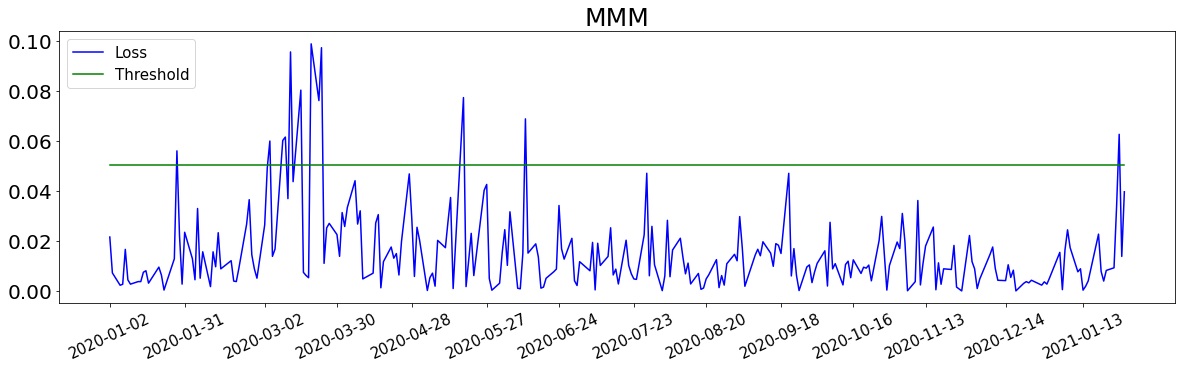

In [ ]:
for i in range(len(stock_id2)): 
# for i in range(1):  
  # test_score_MMM,...,test_score_RTX
   
  fig = plt.figure(figsize = (16,6))

  plt.plot(globals()['test_score_{}'.format(stock_id2[i])].index, globals()['test_score_{}'.format(stock_id2[i])].loss, label='Loss', color='blue')
  plt.plot(globals()['test_score_{}'.format(stock_id2[i])].index, globals()['test_score_{}'.format(stock_id2[i])].threshold, label='Threshold', color='green')
  plt.xticks(globals()['test_score_{}'.format(stock_id2[i])].index[np.arange(0, len(globals()['test_score_{}'.format(stock_id2[i])].index), 20)], rotation=25, fontsize = 15)
  plt.legend(fontsize=15, loc='upper left');

  plt.yticks(fontsize = 20)
  plt.title(stock_id2[i], fontsize = 25)
  plt.savefig('fig/loss_thr/'+stock_id2[i]+'.png', dpi=300, bbox_inches='tight')
  # plt.savefig('fig/loss_thr/'+stock_id2[i]+'.eps', dpi=300)
plt.show()

In [36]:
# anomalies_MMM, ..., anomalies_RTX
for i in range(len(stock_id2)): 
# for i in range(1):    
  globals()['anomalies_{}'.format(stock_id2[i])] = globals()['test_score_{}'.format(stock_id2[i])][globals()['test_score_{}'.format(stock_id2[i])].anomaly == True]
  globals()['anomalies_{}'.format(stock_id2[i])].to_csv('anomalies_'+stock_id2[i]+'.csv')

In [ ]:
anomalies_MMM

loss  threshold  anomaly    return       close
Date                                                          
2020-01-28  0.056034   0.050218     True -0.057223  165.580002
2020-03-04  0.059961   0.050218     True  0.060176  153.979996
2020-03-09  0.060197   0.050218     True -0.062415  144.059998
2020-03-10  0.061543   0.050218     True  0.064140  153.300003
2020-03-12  0.095591   0.050218     True -0.092774  133.580002
2020-03-16  0.080317   0.050218     True -0.076016  130.910004
2020-03-20  0.098826   0.050218     True -0.091775  124.889999
2020-03-23  0.076149   0.050218     True -0.056209  117.870003
2020-03-24  0.097279   0.050218     True  0.125986  132.720001
2020-05-18  0.077339   0.050218     True  0.076285  149.270004
2020-06-11  0.068825   0.050218     True -0.070287  152.380005
2021-01-27  0.062652   0.050218     True  0.060813  186.649994

In [37]:
test.index[TIME_STEPS:]

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2021-01-15', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', name='Date', length=272, freq=None)

In [38]:
for i in range(len(stock_id2)): 
# for i in range(1):    
  fig = plt.figure(figsize = (27,5))

  plt.plot(
    test.index[TIME_STEPS:], 
    df_test[[stock_id2[i]]][TIME_STEPS:], 
    label='Return', color = 'blue'
  );
  
  if globals()['test_score_{}'.format(stock_id2[i])]['anomaly'].sum() !=0:
    plt.scatter(
      globals()['anomalies_{}'.format(stock_id2[i])].index,
      globals()['anomalies_{}'.format(stock_id2[i])][['return']],
      color = 'red',
      s = 60,
      label='Anomaly'
    )

  plt.xticks(test.index[TIME_STEPS:][np.arange(0, len(test.index[TIME_STEPS:]), 20)], rotation=25, fontsize = 15)
  plt.yticks(fontsize = 20)
  plt.legend(fontsize = 15, loc='lower left');
  # plt.title("Return and anomaly points of " + stock_id[i])
  plt.title(stock_id2[i], fontsize = 25)
  plt.savefig('fig/anomalies/'+stock_id2[i]+'.png', dpi=300, bbox_inches='tight')
  # plt.savefig('fig/anomalies/'+stock_id2[i]+'.eps', dpi=300)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

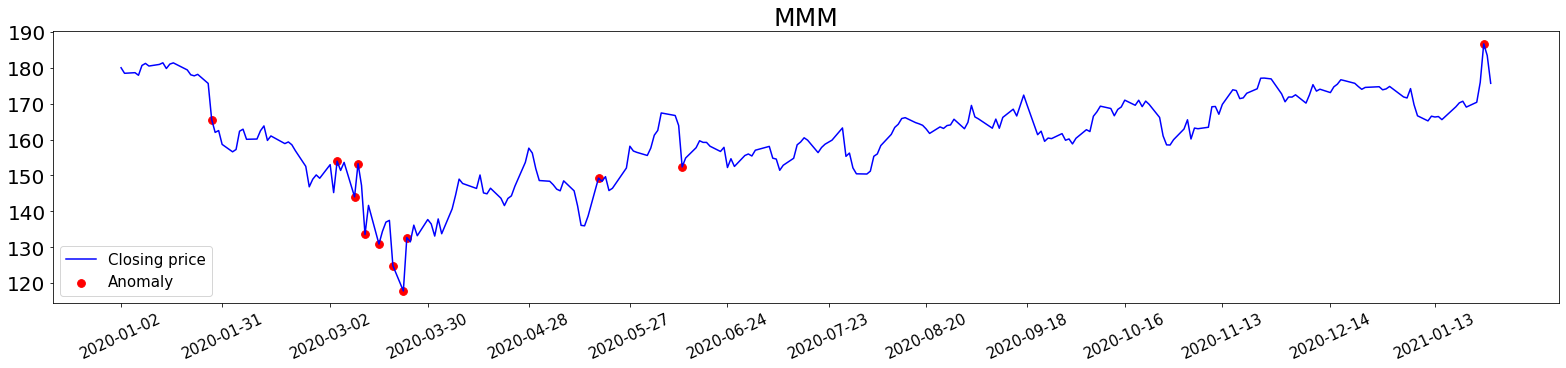

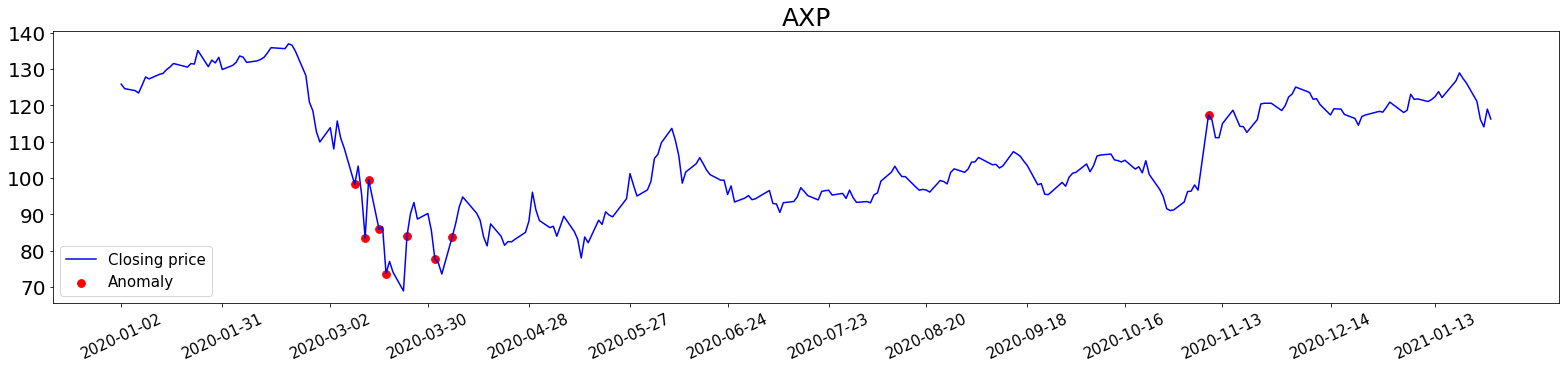

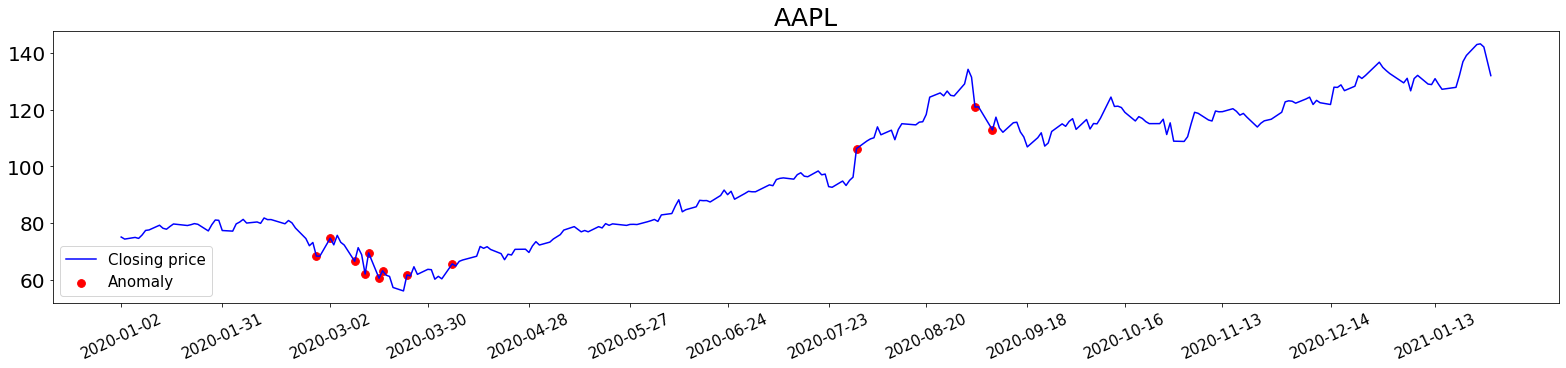

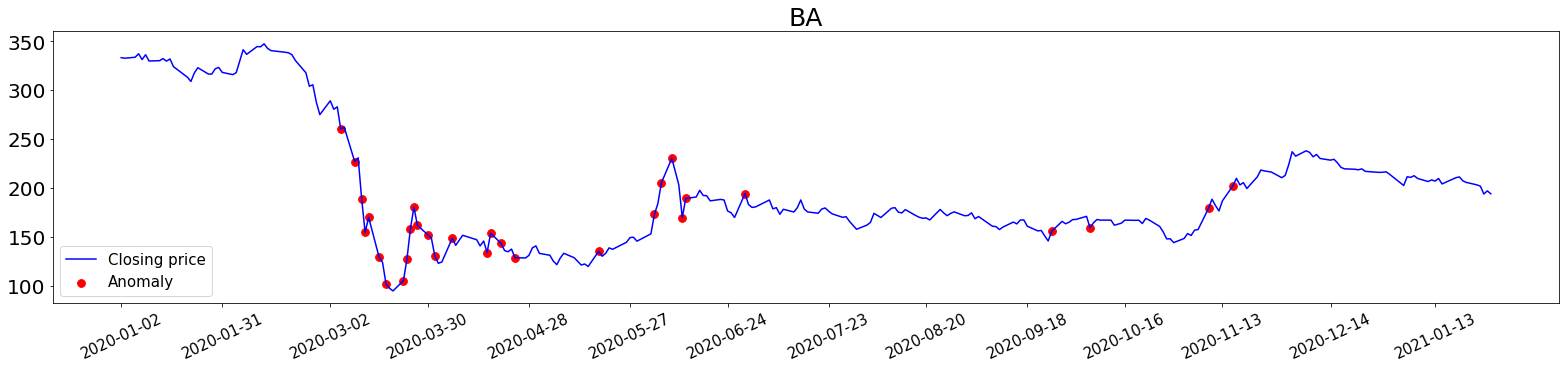

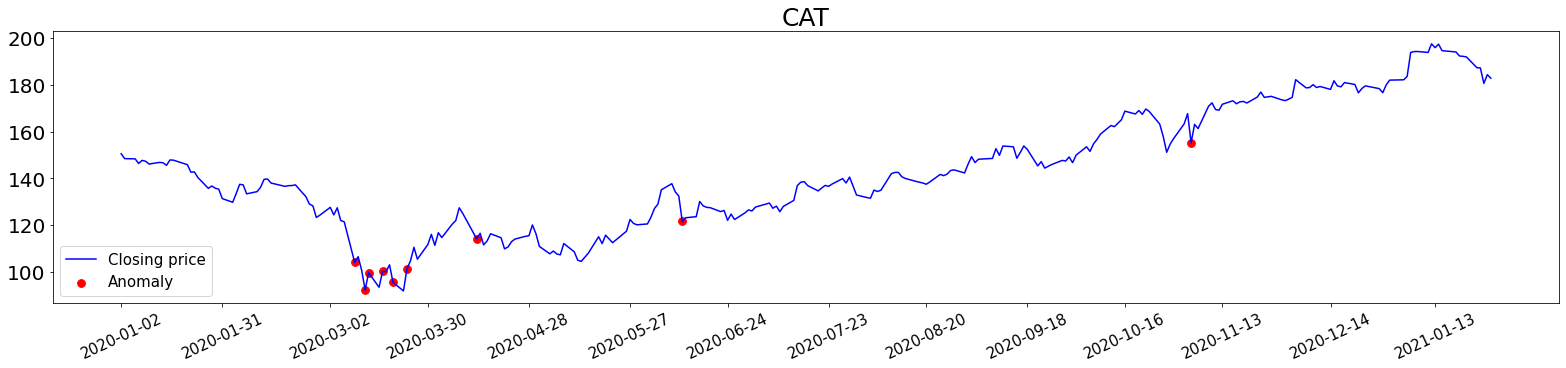

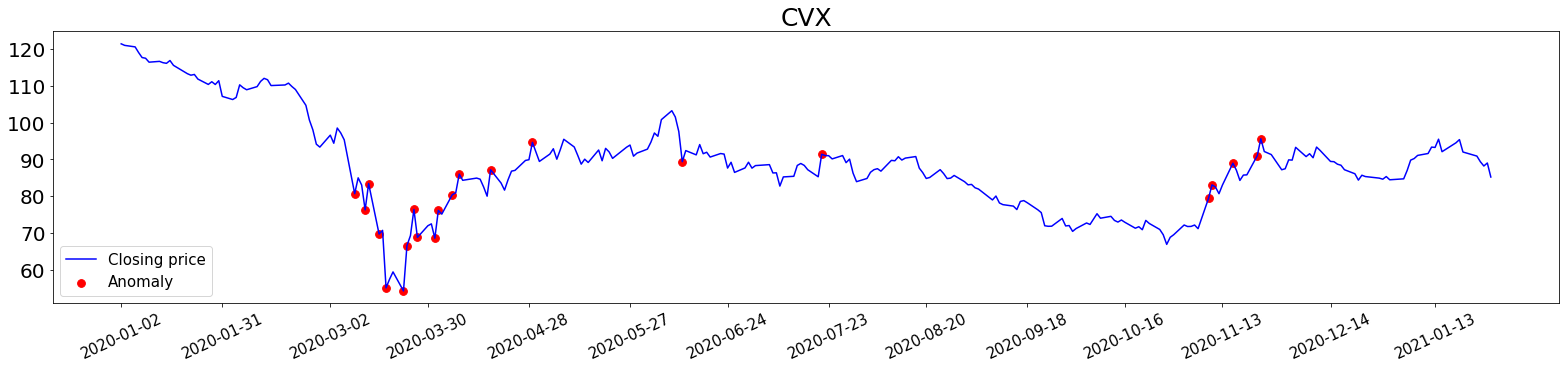

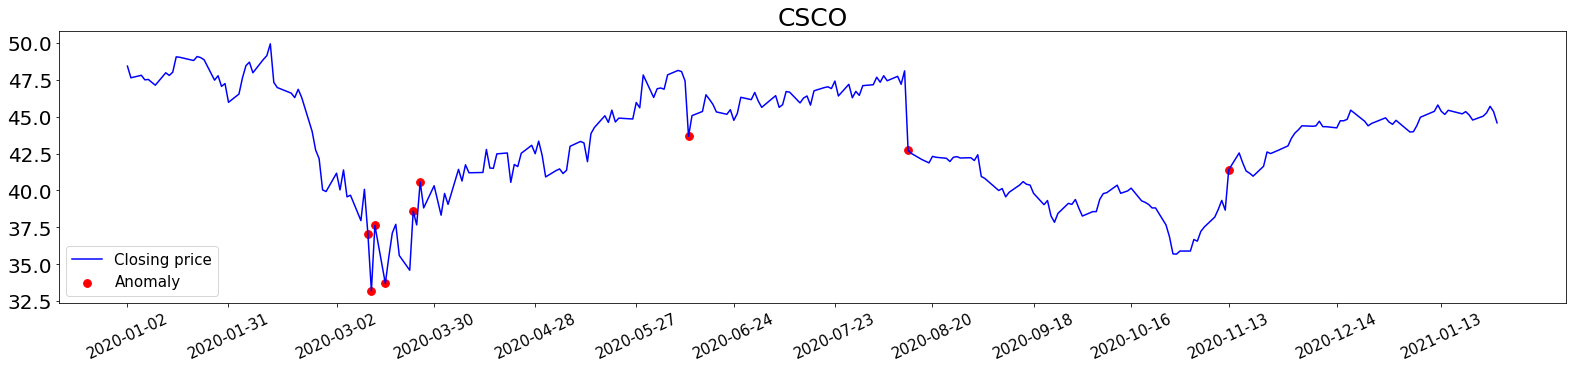

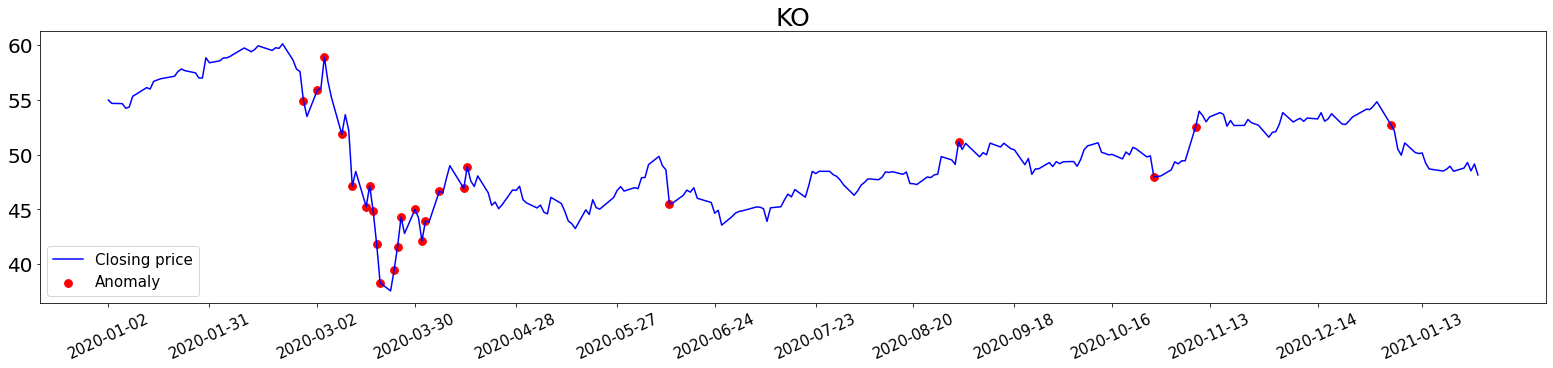

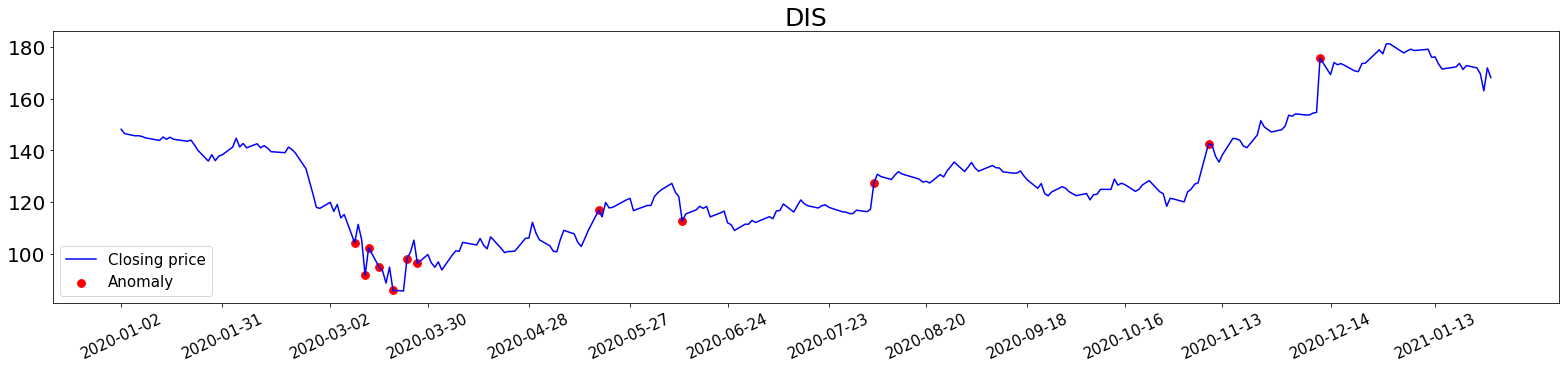

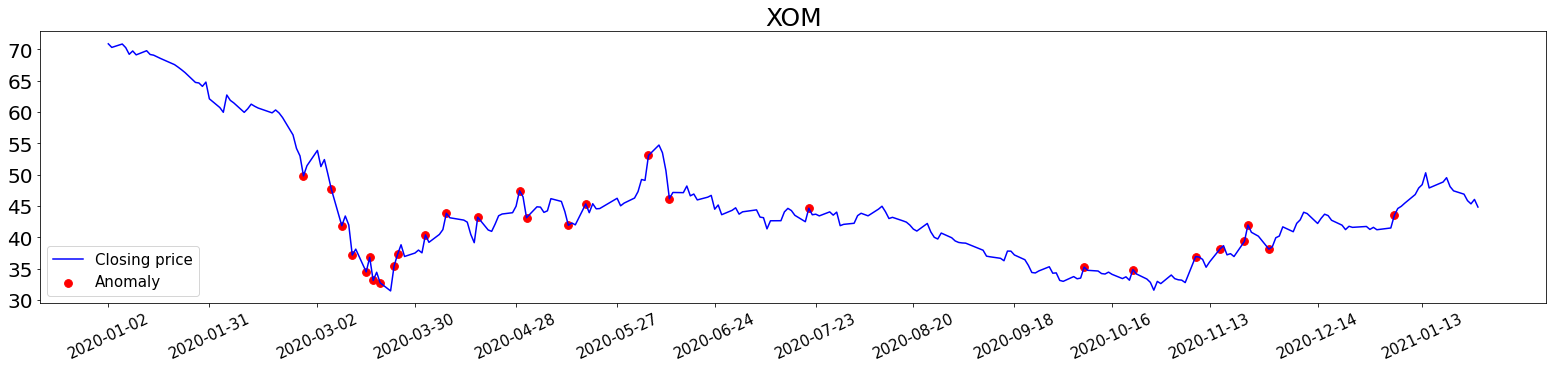

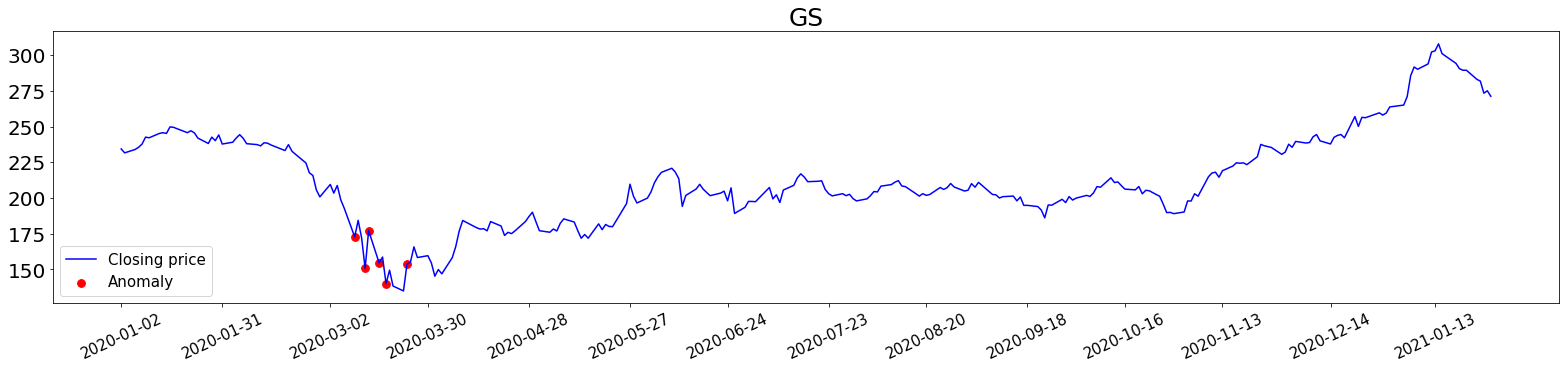

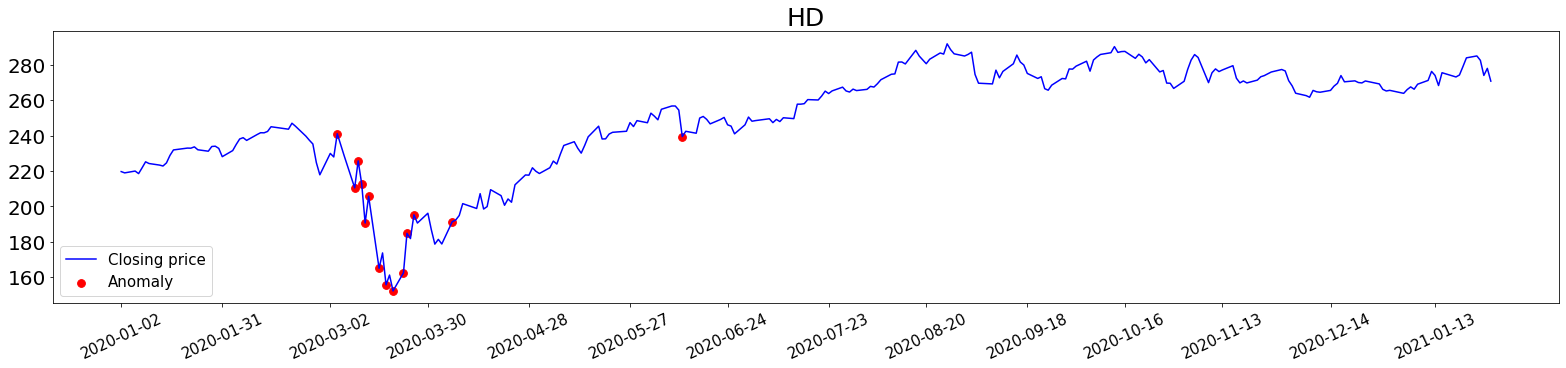

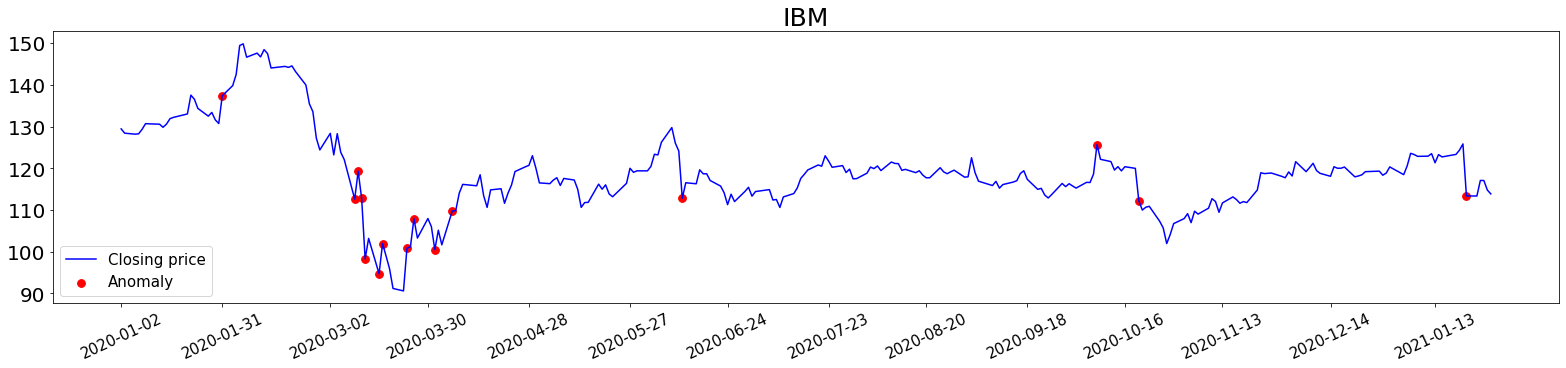

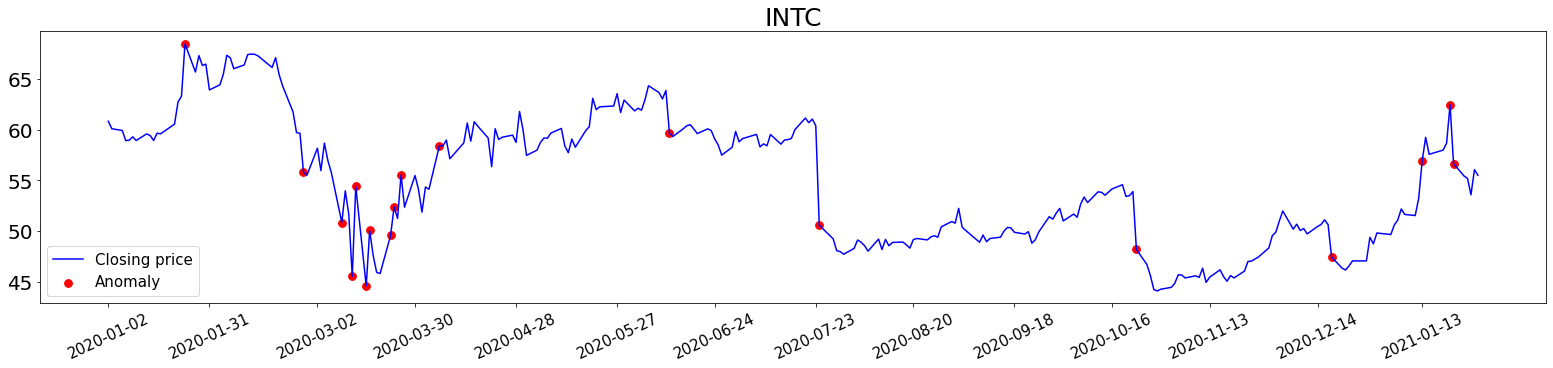

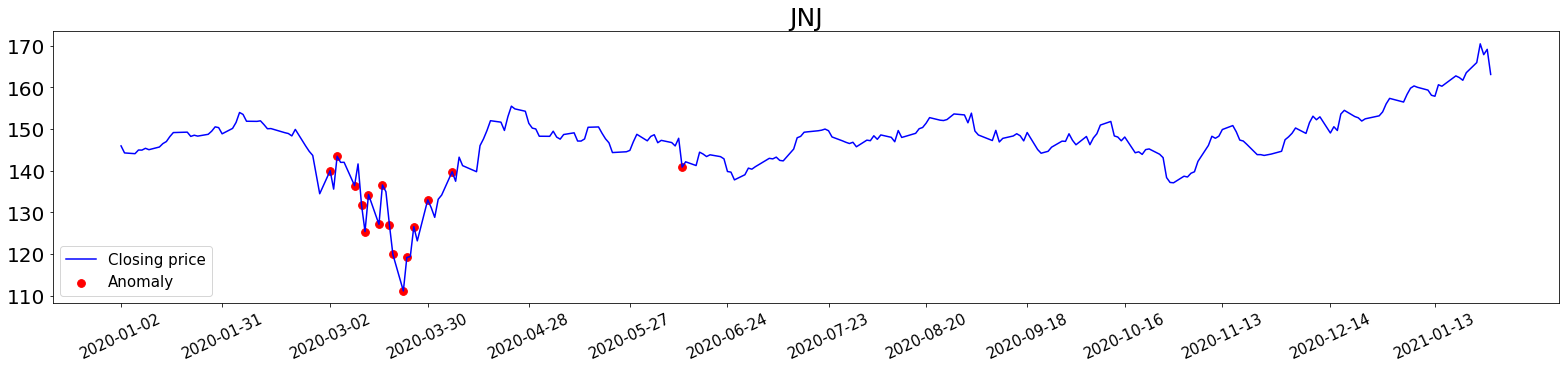

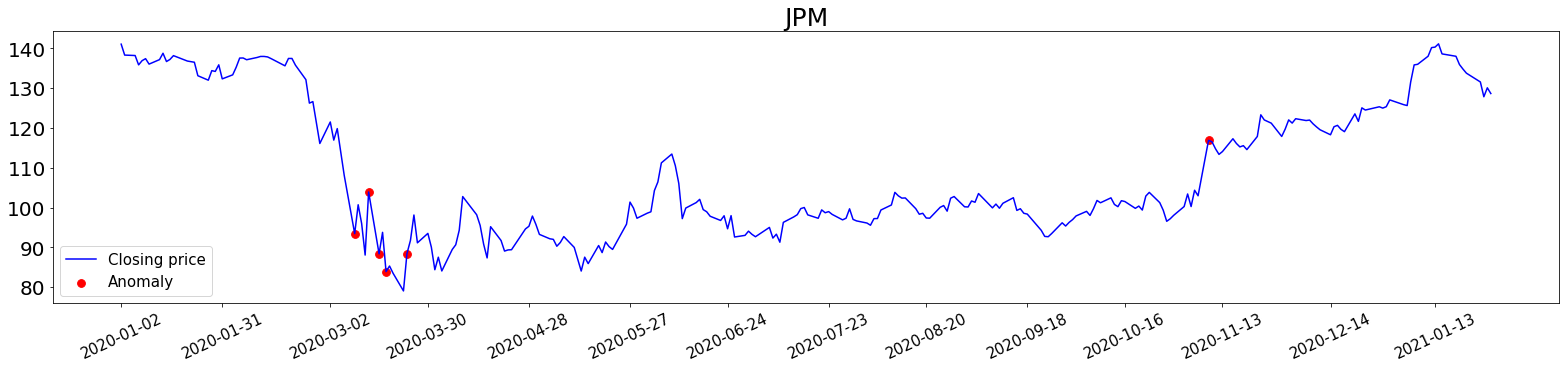

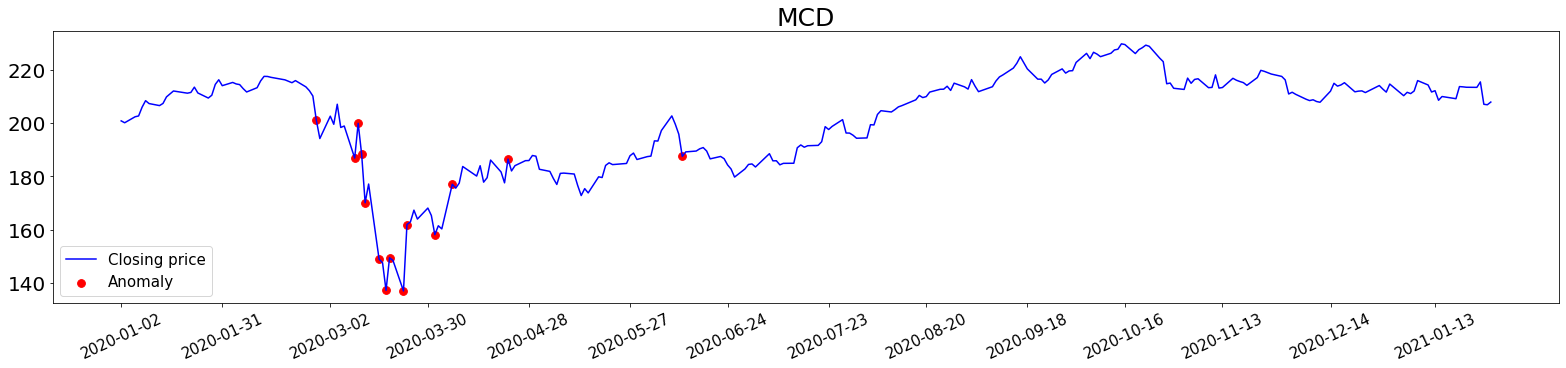

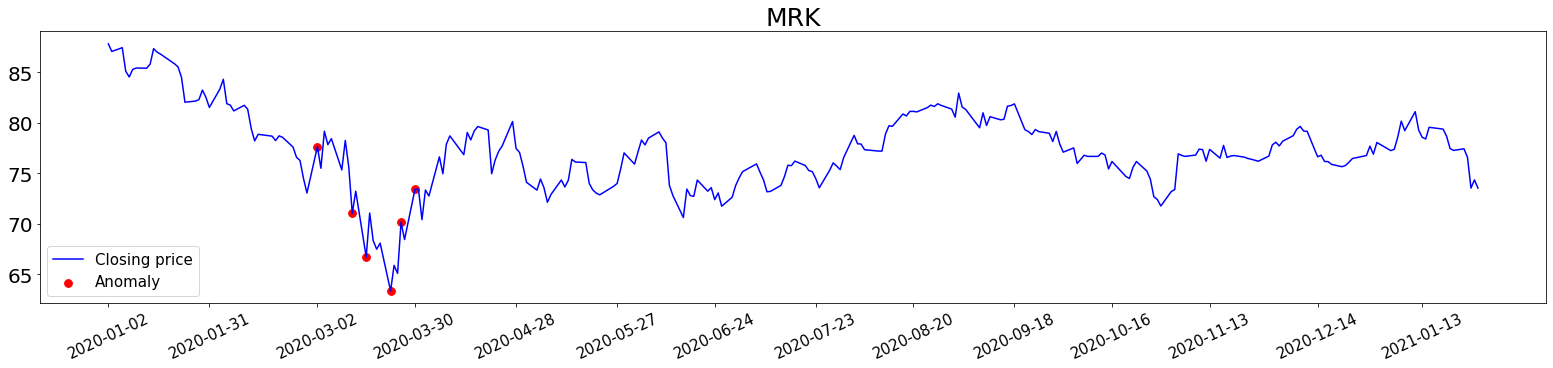

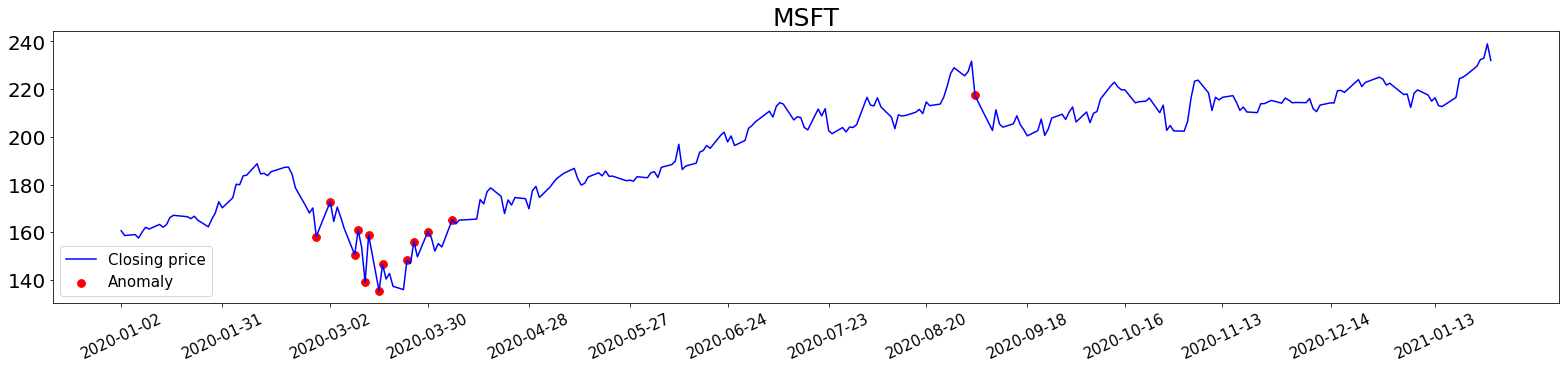

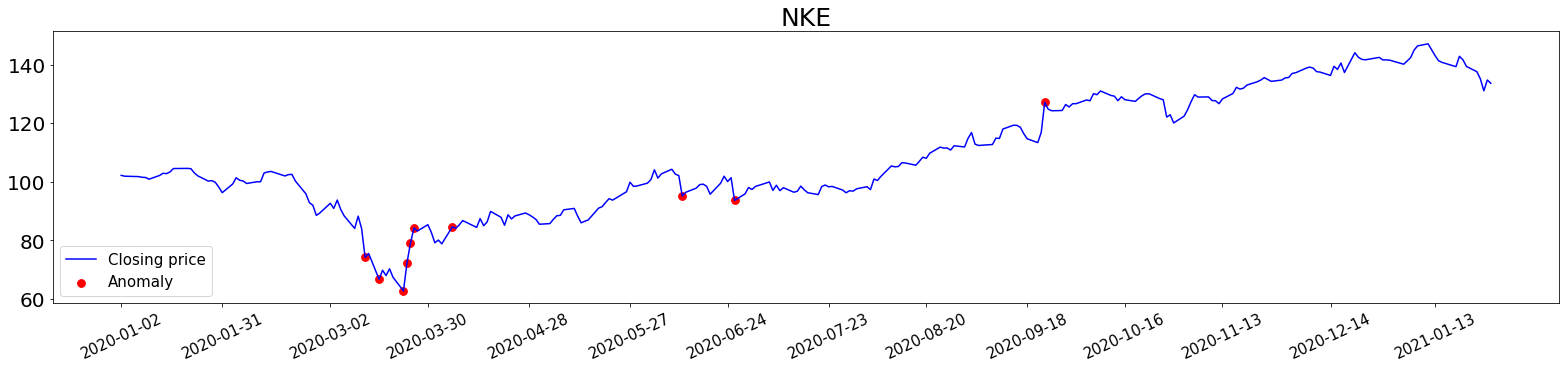

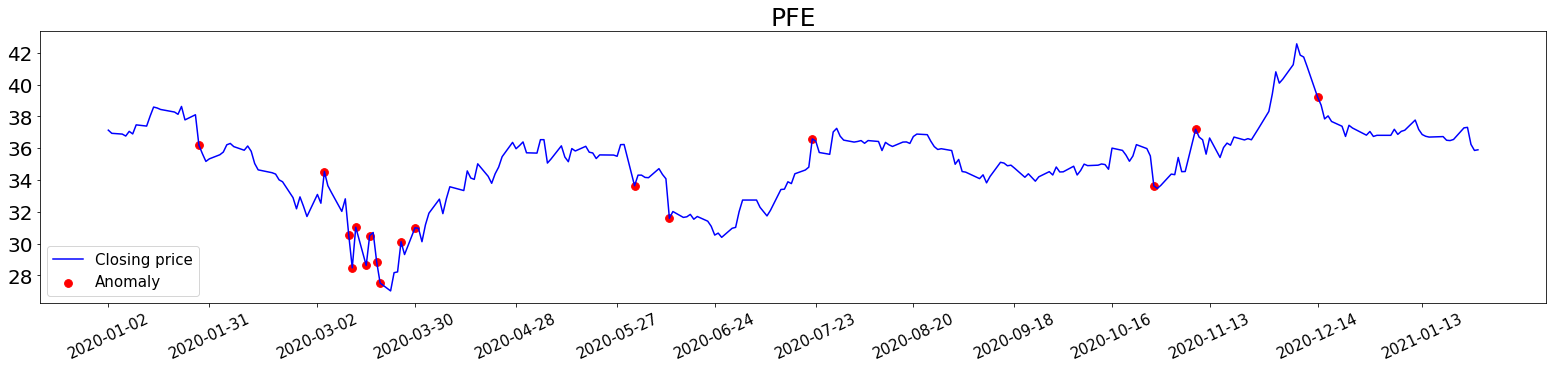

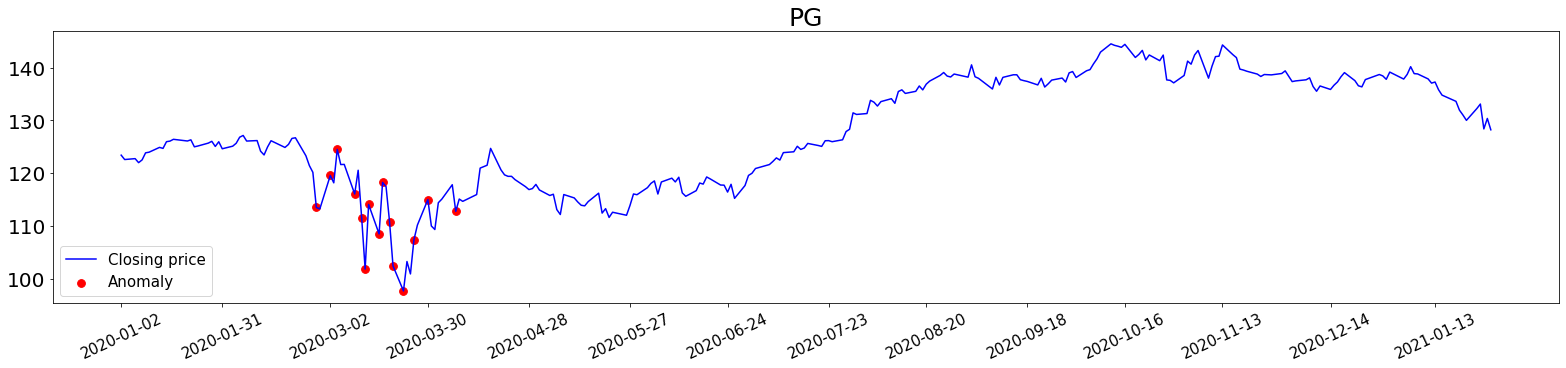

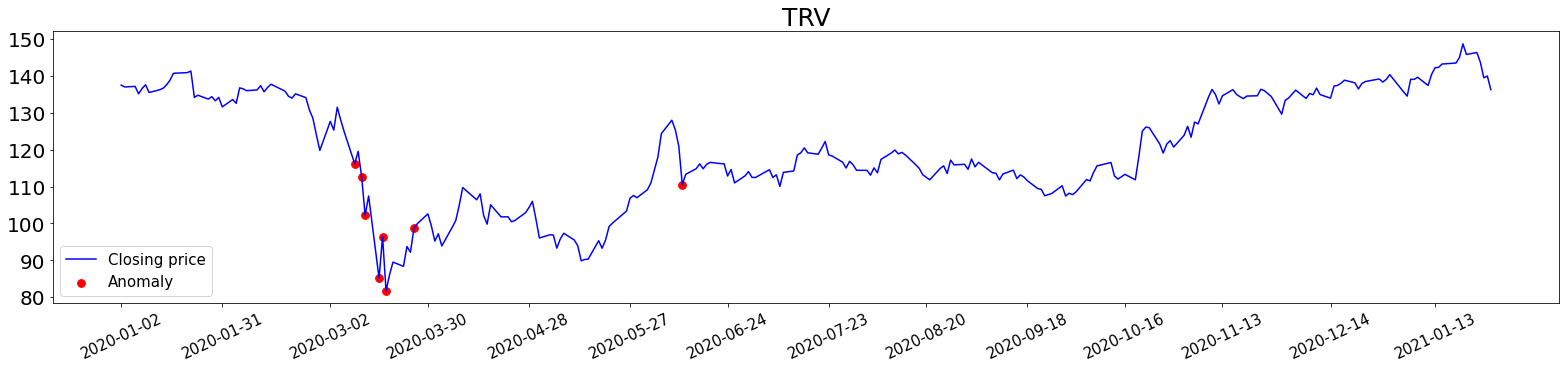

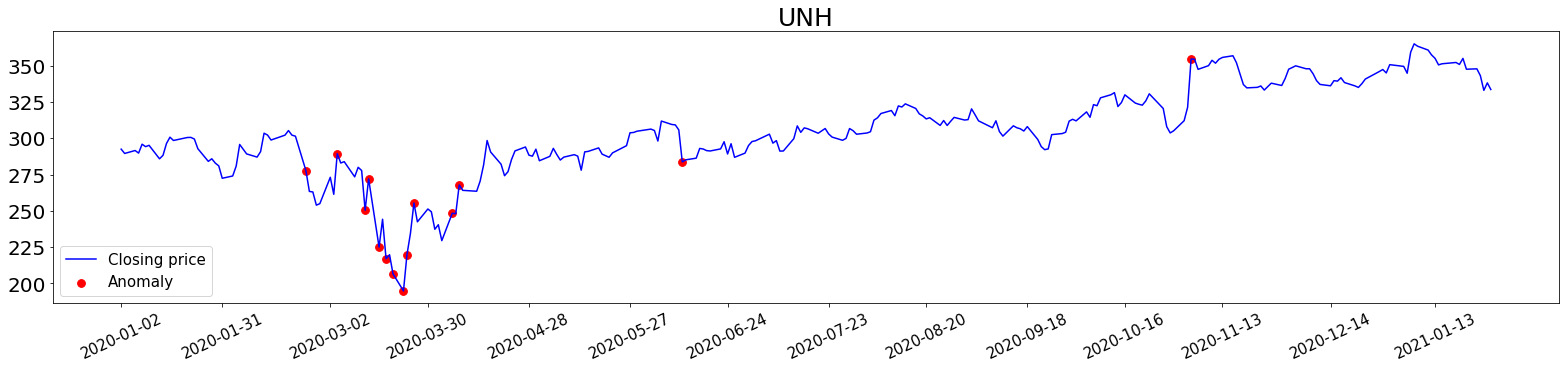

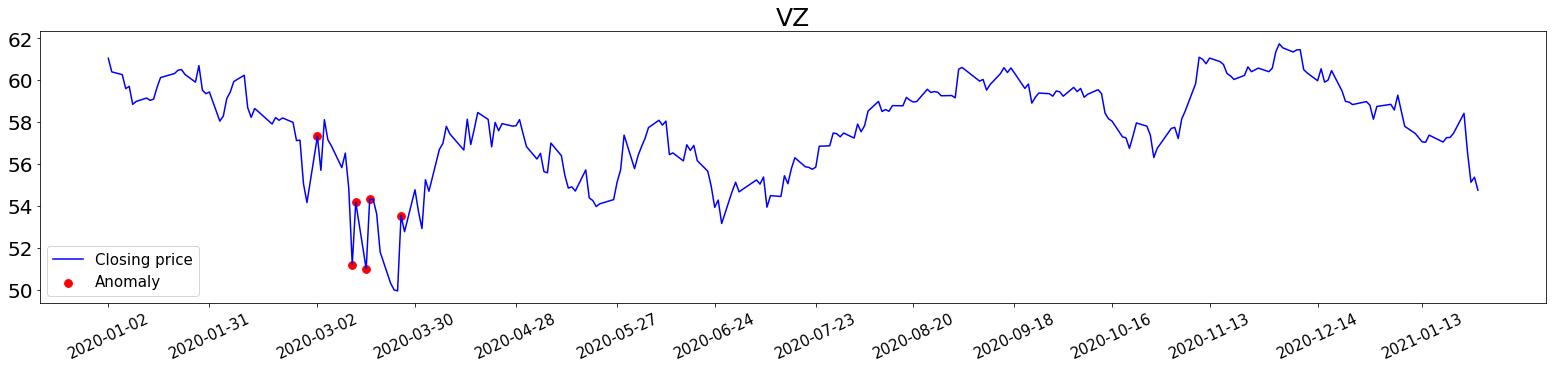

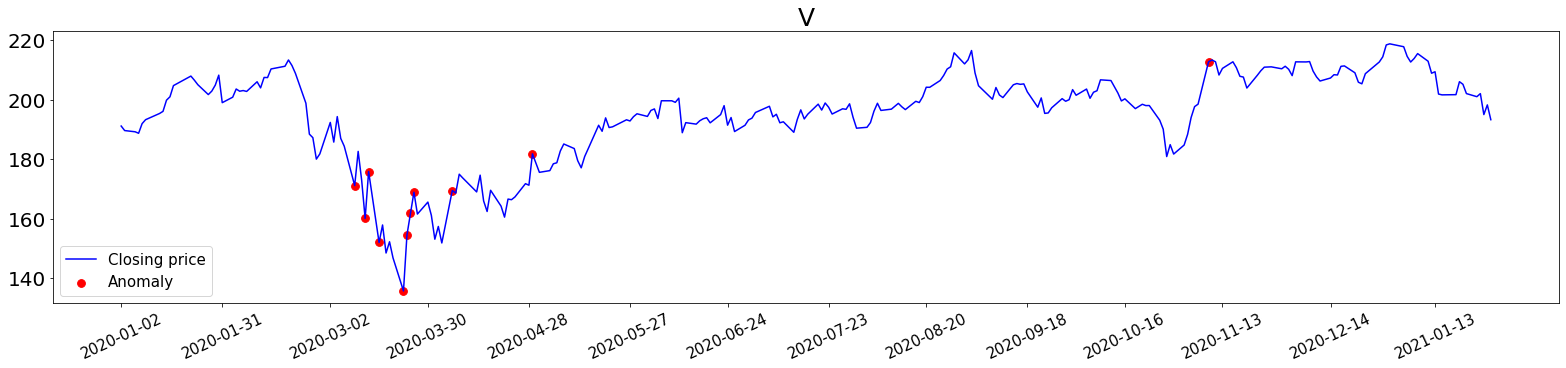

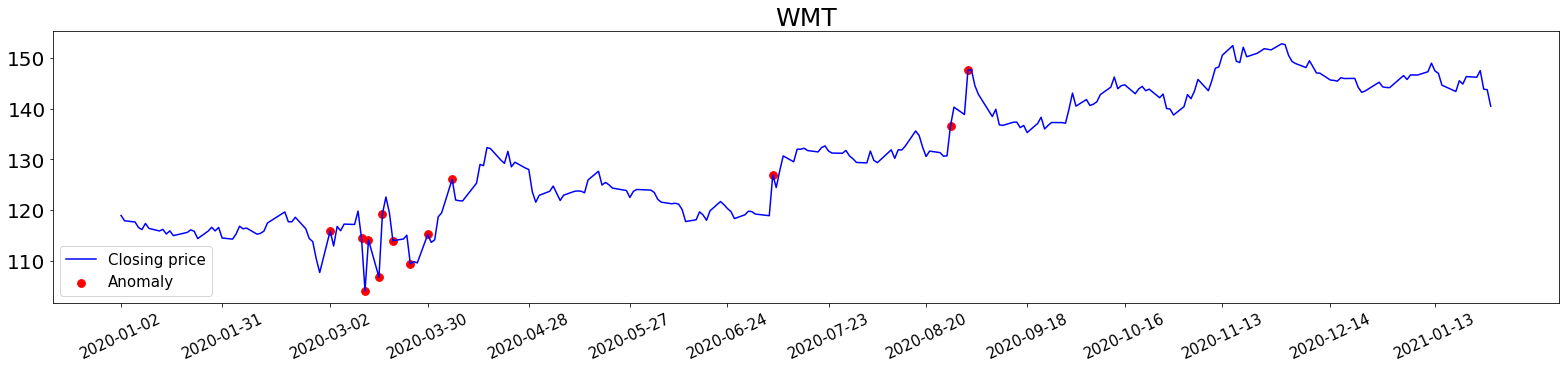

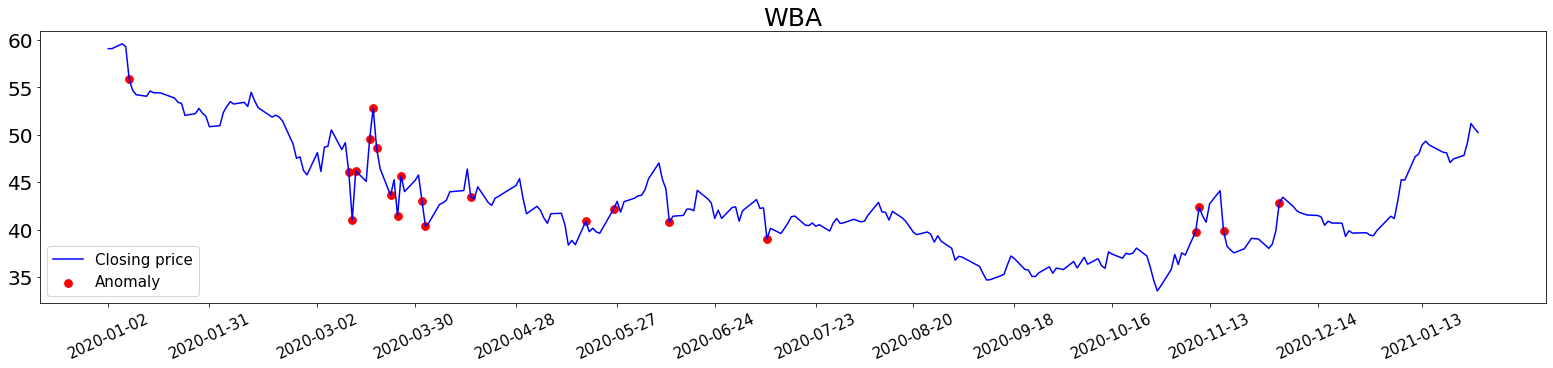

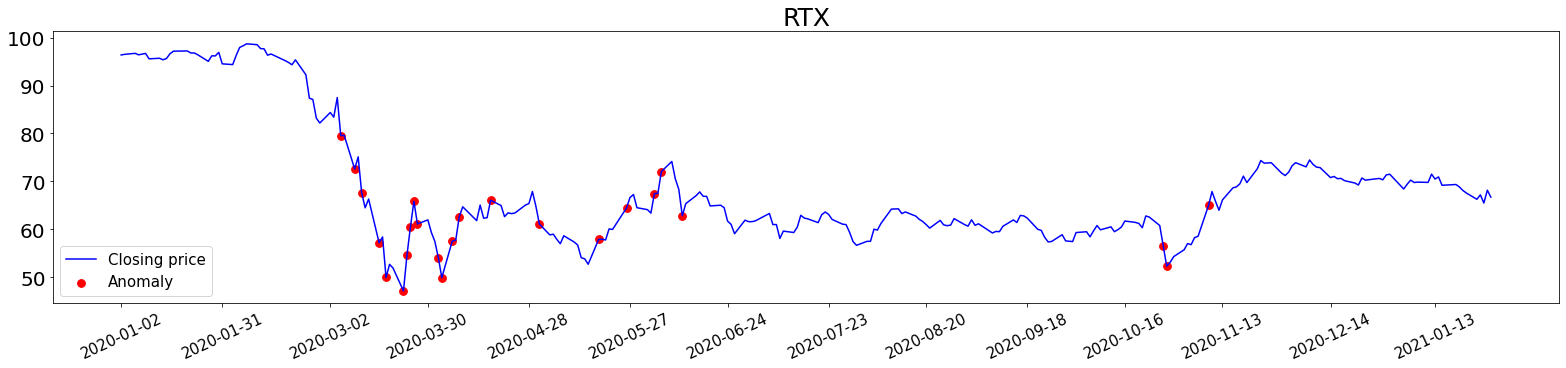

In [39]:
for i in range(len(stock_id2)): 
# for i in range(1):    
  fig = plt.figure(figsize = (27,5))

  plt.plot(
    test.index[TIME_STEPS:], 
    orig_test[[stock_id2[i]]][TIME_STEPS:], 
    label='Closing price', color = 'blue'
  );
  
  if globals()['test_score_{}'.format(stock_id2[i])]['anomaly'].sum() !=0:
    plt.scatter(
      globals()['anomalies_{}'.format(stock_id2[i])].index,
      globals()['anomalies_{}'.format(stock_id2[i])][['close']],
      color = 'red',
      s = 60,
      label='Anomaly'
    )

  plt.xticks(test.index[TIME_STEPS:][np.arange(0, len(test.index[TIME_STEPS:]), 20)], rotation=25, fontsize = 15)
  plt.yticks(fontsize = 20)
  plt.legend(fontsize = 15, loc='lower left');
  # plt.title("Closing price and anomaly points of " + stock_id[i])
  plt.title(stock_id2[i], fontsize = 25)
  plt.savefig('fig/anomalies2/'+stock_id2[i]+'.png', dpi=300, bbox_inches='tight')
  # plt.savefig('fig/anomalies/'+stock_id2[i]+'.eps', dpi=300)
  plt.show()

In [ ]:
for i in range(len(stock_id2)):
# for i in range(1):    
  print(stock_id2[i])
  print(globals()['threshold_{}'.format(stock_id2[i])])

MMM
0.0502179991173733
AXP
0.09184952203243721
AAPL
0.06242749986105456
BA
0.06367118997911994
CAT
0.06949923855507678
CVX
0.05255521497706706
CSCO
0.06363827613318755
KO
0.03757921762152918
DIS
0.062481946524106866
XOM
0.04881162788043512
GS
0.09215301186831455
HD
0.05474591608411913
IBM
0.05018649300796408
INTC
0.06136010560467774
JNJ
0.03600814053428125
JPM
0.10210445512288431
MCD
0.04297309399888229
MRK
0.059800189069542806
MSFT
0.0583730482522372
NKE
0.0639439756712908
PFE
0.04573128469083034
PG
0.03849395194867526
TRV
0.06091680199308768
UNH
0.0705512649291189
VZ
0.04403792201063973
V
0.06085133453198589
WMT
0.040822181706860944
WBA
0.05729576224461106
RTX
0.05487294314430382
